In [ ]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn
!pip install mne
!pip install pywavelets
!pip install tensorflow
!pip install matplotlib
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.9 MB/s eta 0:00:00


In [ ]:
# Base Line DWT, PCA
import os
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import ICA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from scipy.stats import ttest_ind
import pywt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Dense, Flatten, BatchNormalization,
                                     Activation, Dropout)
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import json

# 1. Data Loading

# Update the data path to your dataset directory
data_path = '/content/drive/MyDrive/Thesis_data/unpreprocessed'

# Define the path to save preprocessed data
preprocessed_data_path = '/content/drive/MyDrive/EEGDAT/preprocessed_data'

# Create the directory if it doesn't exist
if not os.path.exists(preprocessed_data_path):
    os.makedirs(preprocessed_data_path)

# Read participants.tsv to get subject IDs and labels
participants_tsv = os.path.join(data_path, '/content/drive/MyDrive/EEGDAT/participants.tsv')
participants_df = pd.read_csv(participants_tsv, sep='\t')

# Map diagnoses to numerical labels using 'Group' column
diagnosis_mapping = {'C': 0, 'A': 1, 'F': 2}
participants_df['label'] = participants_df['Group'].map(diagnosis_mapping)

# Create a dictionary of labels
labels = dict(zip(participants_df['participant_id'], participants_df['label']))

# List of subject IDs
subject_ids = participants_df['participant_id'].tolist()

# Function to get EEG file path
def get_eeg_file(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    eeg_file = None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.set') or file.endswith('_eeg.SET'):
            eeg_file = os.path.join(sub_folder, file)
            break
    if eeg_file is None:
        print(f"No EEG file found in {sub_folder} for subject {sub_id}")
    return eeg_file

# Function to read channel information
def read_channel_info(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    channels_tsv = None
    for file in os.listdir(sub_folder):
        if file.endswith('_channels.tsv') or file.endswith('_CHANNELS.TSV'):
            channels_tsv = os.path.join(sub_folder, file)
            break
    if channels_tsv:
        channels_df = pd.read_csv(channels_tsv, sep='\t')
        return channels_df
    else:
        return None

# Function to read metadata from JSON file
def read_metadata(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    json_file = None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.json') or file.endswith('_EEG.JSON'):
            json_file = os.path.join(sub_folder, file)
            break
    if json_file:
        with open(json_file, 'r') as f:
            metadata = json.load(f)
        return metadata
    else:
        return None

# 2. Preprocessing Functions

def preprocess_eeg(raw, channels_df=None, metadata=None):
    """
    Preprocess the raw EEG data.
    """
    # If channel information is provided, set channel types
    if channels_df is not None:
        ch_names = channels_df['name'].tolist()
        # Convert channel types to lowercase to match MNE's expected types
        ch_types = channels_df['type'].str.lower().tolist()
        mapping = dict(zip(ch_names, ch_types))
        raw.set_channel_types(mapping)

    # Set the EEG montage (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    # Re-reference the data to average of A1 and A2 (if present)
    if 'A1' in raw.ch_names and 'A2' in raw.ch_names:
        raw.set_eeg_reference(['A1', 'A2'])
    else:
        raw.set_eeg_reference('average', projection=False)

    # Band-pass filter (0.5–45 Hz)
    raw.filter(0.5, 45., fir_design='firwin')

    # Independent Component Analysis (ICA) with automatic artifact rejection
    ica = ICA(n_components=15, random_state=97, max_iter='auto')
    ica.fit(raw)

    # Use 'Fp1' and 'Fp2' as proxy EOG channels
    eog_channels = ['Fp1', 'Fp2']
    available_eog_channels = [ch for ch in eog_channels if ch in raw.ch_names]

    if available_eog_channels:
        # Use the available EOG proxy channels for artifact detection
        eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=available_eog_channels)
    else:
        print("No frontal channels available for EOG detection. Proceeding without EOG correction.")
        eog_indices = []

    # Exclude identified EOG components
    ica.exclude.extend(eog_indices)

    # Apply ICA to remove artifacts
    raw = ica.apply(raw)

    # Create fixed-length epochs (e.g., 2 seconds)
    events = mne.make_fixed_length_events(raw, start=0, duration=2.0)
    event_id = {'Rest': 1}

    # Epoching
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Exclude bad epochs
    epochs.drop_bad()

    return epochs

# 3. Feature Extraction Methods

import pywt

def extract_features_dwt(epochs, summary_stats=True):
    """
    Extract features using Discrete Wavelet Transform from epochs.

    Parameters:
    - epochs: MNE Epochs object or similar structure with get_data method.
    - summary_stats: If True, calculates mean and std of each level's coefficients.
                     If False, returns the full flattened coefficients.

    Returns:
    - A numpy array of features for each epoch.
    """
    features = []
    for epoch in epochs.get_data():
        epoch_features = []
        for ch in range(epoch.shape[0]):
            coeffs = pywt.wavedec(epoch[ch, :], 'db4', level=5)
            if summary_stats:
                ch_features = []
                for coeff in coeffs:
                    ch_features.append(np.mean(coeff))
                    ch_features.append(np.std(coeff))
                epoch_features.extend(ch_features)
            else:
                coeffs_flat = np.hstack(coeffs)
                epoch_features.extend(coeffs_flat)
        features.append(epoch_features)
    return np.array(features)

# 3.2 Principal Component Analysis (PCA) with Cross-Covariance (CCOV)
def extract_features_pca_ccov(epochs):
    """
    Extract features using PCA with Cross-Covariance from epochs.
    """
    features = []
    for epoch in epochs.get_data():
        # Compute cross-covariance matrix
        cov_matrix = np.cov(epoch)
        # Apply PCA
        pca = PCA(n_components=10)  # Adjust the number of components as needed
        pca.fit(cov_matrix)
        epoch_features = pca.components_.flatten()
        features.append(epoch_features)
    return np.array(features)

# 4. EEGNet Model Implementation

def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16,
           norm_rate=0.25, dropoutType='Dropout'):
    """
    EEGNet model as per the original architecture.
    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError("dropoutType must be one of 'Dropout' or 'SpatialDropout2D'")

    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D,
                             use_bias=False, depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classification block
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=tf.keras.constraints.MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    return model

# 5. Data Preparation and Feature Extraction

# Initialize lists to store data and labels
X_baseline = []
y_baseline = []
X_dwt = []
y_dwt = []
X_pca = []
y_pca = []

for sub_id in subject_ids:
    print(f"Processing {sub_id}...")

    # Define the path to the preprocessed data file
    preprocessed_file = os.path.join(preprocessed_data_path, f"{sub_id}_epo.fif")

    if os.path.exists(preprocessed_file):
        # Load preprocessed data
        print(f"Loading preprocessed data for {sub_id}...")
        epochs = mne.read_epochs(preprocessed_file, preload=True)
    else:
        # Get EEG file path
        eeg_file = get_eeg_file(sub_id)
        if eeg_file is None:
            print(f"No EEG file found for {sub_id}. Skipping.")
            continue

        # Load raw EEG data using EEGLAB reader
        try:
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
        except Exception as e:
            print(f"Error loading EEG data for {sub_id}: {e}")
            continue

        # Read channel information
        channels_df = read_channel_info(sub_id)

        # Read metadata (if needed)
        metadata = read_metadata(sub_id)

        # Preprocess the data
        try:
            epochs = preprocess_eeg(raw, channels_df, metadata)
        except Exception as e:
            print(f"Error preprocessing EEG data for {sub_id}: {e}")
            continue

        # Save the preprocessed data
        epochs.save(preprocessed_file, overwrite=True)
        print(f"Preprocessed data saved for {sub_id}.")

    # Get the data from epochs
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    if data.size == 0:
        print(f"No data in epochs for {sub_id}. Skipping.")
        continue

    print(f"Data shape for {sub_id}: {data.shape}")

    # Append to baseline dataset
    X_baseline.extend(data)
    y_baseline.extend([labels[sub_id]] * data.shape[0])

    # Feature Extraction: DWT
    try:
        features_dwt = extract_features_dwt(epochs)
        X_dwt.extend(features_dwt)
        y_dwt.extend([labels[sub_id]] * features_dwt.shape[0])
    except Exception as e:
        print(f"Error in DWT feature extraction for {sub_id}: {e}")
        continue

    # Feature Extraction: PCA with CCOV
    try:
        features_pca = extract_features_pca_ccov(epochs)
        X_pca.extend(features_pca)
        y_pca.extend([labels[sub_id]] * features_pca.shape[0])
    except Exception as e:
        print(f"Error in PCA feature extraction for {sub_id}: {e}")
        continue

# 6. Data Conversion and Splitting

# Convert lists to numpy arrays
X_baseline = np.array(X_baseline)  # Shape: (total_epochs, n_channels, n_times)
y_baseline = np.array(y_baseline)
X_dwt = np.array(X_dwt)
y_dwt = np.array(y_dwt)
X_pca = np.array(X_pca)
y_pca = np.array(y_pca)

# Check if data is loaded
if len(X_baseline) == 0 or len(y_baseline) == 0:
    print("No data was loaded. Please check data loading and preprocessing steps.")
else:
    # For EEGNet, reshape data to fit the model input
    X_baseline = X_baseline[..., np.newaxis]  # Shape: (samples, channels, times, 1)

    # One-hot encode the labels for classification
    num_classes = len(np.unique(y_baseline))
    y_baseline_cat = to_categorical(y_baseline, num_classes)
    y_dwt_cat = to_categorical(y_dwt, num_classes)
    y_pca_cat = to_categorical(y_pca, num_classes)

    # Split the data into training and testing sets
    X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        X_baseline, y_baseline_cat, test_size=0.2, random_state=42, stratify=y_baseline)

    X_train_dwt, X_test_dwt, y_train_dwt, y_test_dwt = train_test_split(
        X_dwt, y_dwt_cat, test_size=0.2, random_state=42, stratify=y_dwt)

    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
        X_pca, y_pca_cat, test_size=0.2, random_state=42, stratify=y_pca)

    # 7. Model Training and Evaluation

    # Create the directory to save models if it doesn't exist
    model_save_path = '/content/drive/MyDrive/Thesis_data/code'
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    # 7.1 Training on Baseline Dataset
    model_base = EEGNet(nb_classes=num_classes, Chans=X_baseline.shape[1], Samples=X_baseline.shape[2])
    model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_base = model_base.fit(X_train_base, y_train_base, epochs=50, batch_size=16,
                                  validation_data=(X_test_base, y_test_base))

    # Save the baseline model
    model_base.save(os.path.join(model_save_path, 'model_base.h5'))
    print("Baseline model saved.")

    # 7.2 Training on DWT Features
    model_dwt = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(X_dwt.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    print(X_dwt.shape)
    model_dwt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_dwt = model_dwt.fit(X_train_dwt, y_train_dwt, epochs=50, batch_size=16,
                                validation_data=(X_test_dwt, y_test_dwt))

    # Save the DWT model
    model_dwt.save(os.path.join(model_save_path, 'model_dwt.h5'))
    print("DWT model saved.")

    # 7.3 Training on PCA with CCOV Features
    model_pca = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_pca.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    print(X_pca.shape)
    model_pca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_pca = model_pca.fit(X_train_pca, y_train_pca, epochs=50, batch_size=16,
                                validation_data=(X_test_pca, y_test_pca))

    # Save the PCA model
    model_pca.save(os.path.join(model_save_path, 'model_pca.h5'))
    print("PCA model saved.")

    # 8. Evaluation Metrics

    # Predict on the test sets
    y_pred_base = model_base.predict(X_test_base)
    y_pred_dwt = model_dwt.predict(X_test_dwt)
    y_pred_pca = model_pca.predict(X_test_pca)

    # Convert predictions and true labels to class labels
    y_pred_base_cls = np.argmax(y_pred_base, axis=1)
    y_true_base_cls = np.argmax(y_test_base, axis=1)

    y_pred_dwt_cls = np.argmax(y_pred_dwt, axis=1)
    y_true_dwt_cls = np.argmax(y_test_dwt, axis=1)

    y_pred_pca_cls = np.argmax(y_pred_pca, axis=1)
    y_true_pca_cls = np.argmax(y_test_pca, axis=1)

    # Calculate evaluation metrics
    def evaluate_model(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        sensitivity = recall_score(y_true, y_pred, average='macro')
        # Specificity calculation for multiclass
        specificity = []
        for i in range(num_classes):
            tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
            fp = np.sum(np.delete(cm[:, i], i))
            specificity.append(tn / (tn + fp))
        specificity = np.mean(specificity)
        return acc, sensitivity, specificity, cm

        # Baseline model evaluation
    acc_base, sens_base, spec_base, cm_base = evaluate_model(y_true_base_cls, y_pred_base_cls)

    # DWT model evaluation
    acc_dwt, sens_dwt, spec_dwt, cm_dwt = evaluate_model(y_true_dwt_cls, y_pred_dwt_cls)

    # PCA model evaluation
    acc_pca, sens_pca, spec_pca, cm_pca = evaluate_model(y_true_pca_cls, y_pred_pca_cls)

    # Print the results
    print(f"Baseline Model - Accuracy: {acc_base:.4f}, Sensitivity: {sens_base:.4f}, Specificity: {spec_base:.4f}")
    print(f"DWT Model - Accuracy: {acc_dwt:.4f}, Sensitivity: {sens_dwt:.4f}, Specificity: {spec_dwt:.4f}")
    print(f"PCA Model - Accuracy: {acc_pca:.4f}, Sensitivity: {sens_pca:.4f}, Specificity: {spec_pca:.4f}")

    # Define class labels
    class_labels = ['C', 'A', 'F']  # Adjust labels according to your mapping

    # Import seaborn and matplotlib if not already imported
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Plot confusion matrix for Baseline Model
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix for Baseline Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot confusion matrix for DWT Model
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dwt, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix for DWT Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot confusion matrix for PCA Model
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix for PCA Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 9. Statistical Tests

    # Function for cross-validation evaluation
    def cross_val_evaluate(model_func, X, y, epochs=50, batch_size=16):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = []
        for train_index, test_index in skf.split(X, np.argmax(y, axis=1)):
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            model = model_func()
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
            y_pred_fold = model.predict(X_test_fold)
            y_pred_cls = np.argmax(y_pred_fold, axis=1)
            y_true_cls = np.argmax(y_test_fold, axis=1)
            acc = accuracy_score(y_true_cls, y_pred_cls)
            accuracies.append(acc)
        return np.array(accuracies)

    # Define model creation functions
    def create_eegnet_model():
        return EEGNet(nb_classes=num_classes, Chans=X_baseline.shape[1], Samples=X_baseline.shape[2])

    def create_dwt_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu', input_shape=(X_dwt.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

    def create_pca_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(X_pca.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

    # Perform cross-validation
    print("Performing cross-validation for Baseline Model...")
    acc_base_array = cross_val_evaluate(create_eegnet_model, X_baseline, y_baseline_cat)

    print("Performing cross-validation for DWT Model...")
    acc_dwt_array = cross_val_evaluate(create_dwt_model, X_dwt, y_dwt_cat)

    print("Performing cross-validation for PCA Model...")
    acc_pca_array = cross_val_evaluate(create_pca_model, X_pca, y_pca_cat)

    # Perform t-tests
    t_stat_dwt, p_value_dwt = ttest_ind(acc_base_array, acc_dwt_array)
    t_stat_pca, p_value_pca = ttest_ind(acc_base_array, acc_pca_array)

    print(f"T-test between Baseline and DWT Model: t-statistic={t_stat_dwt:.4f}, p-value={p_value_dwt:.4f}")
    print(f"T-test between Baseline and PCA Model: t-statistic={t_stat_pca:.4f}, p-value={p_value_pca:.4f}")


Processing sub-001...
Loading preprocessed data for sub-001...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-001_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-001: (299, 19, 1001)
Processing sub-002...
Loading preprocessed data for sub-002...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-002_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-002: (396, 19, 1001)
Processing sub-003...
Loading preprocessed data for sub-003...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-003_epo.fif ...
    Found the data of interest:
        t =       0

KeyboardInterrupt: 

Processing sub-001...
Loading preprocessed data for sub-001...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-001_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-001: (299, 19, 1001)
Processing sub-002...
Loading preprocessed data for sub-002...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-002_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-002: (396, 19, 1001)
Processing sub-003...
Loading preprocessed data for sub-003...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-003_epo.fif ...
    Found the data of interest:
        t =       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Baseline model saved.
Epoch 1/50
1255/1255 [==============================] - 40s 31ms/step - loss: 1.0991 - accuracy: 0.3331 - val_loss: 1.0989 - val_accuracy: 0.3335
Epoch 2/50
1255/1255 [==============================] - 36s 29ms/step - loss: 1.0989 - accuracy: 0.3348 - val_loss: 1.0989 - val_accuracy: 0.3337
Epoch 3/50
1255/1255 [==============================] - 38s 30ms/step - loss: 1.0992 - accuracy: 0.3355 - val_loss: 1.0988 - val_accuracy: 0.3337
Epoch 4/50
1255/1255 [==============================] - 37s 30ms/step - loss: 1.0991 - accuracy: 0.3301 - val_loss: 1.0986 - val_accuracy: 0.3337
Epoch 5/50
1255/1255 [==============================] - 38s 30ms/step - loss: 1.0988 - accuracy: 0.3314 - val_loss: 1.0984 - val_accuracy: 0.3351
Epoch 6/50
1255/1255 [==============================] - 37s 30ms/step - loss: 1.0982 - accuracy: 0.3384 - val_loss: 1.0975 - val_accuracy: 0.3341
Epoch 7/50
1255/1255 [==============================] - 38s 30ms/step - loss: 1.0972 - accuracy: 0.334

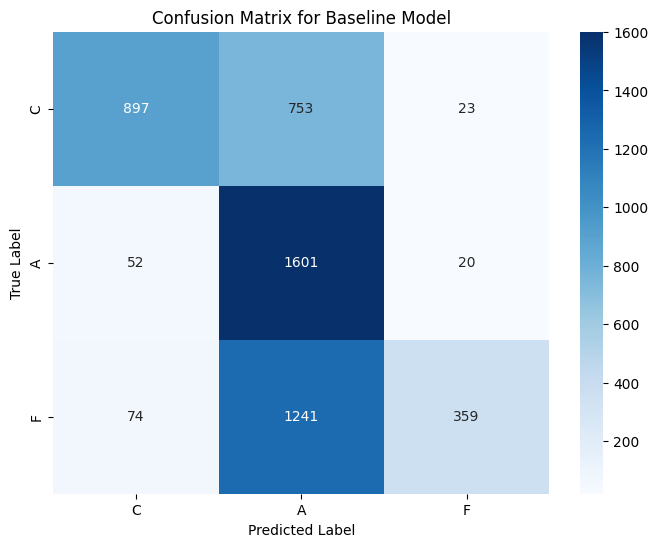

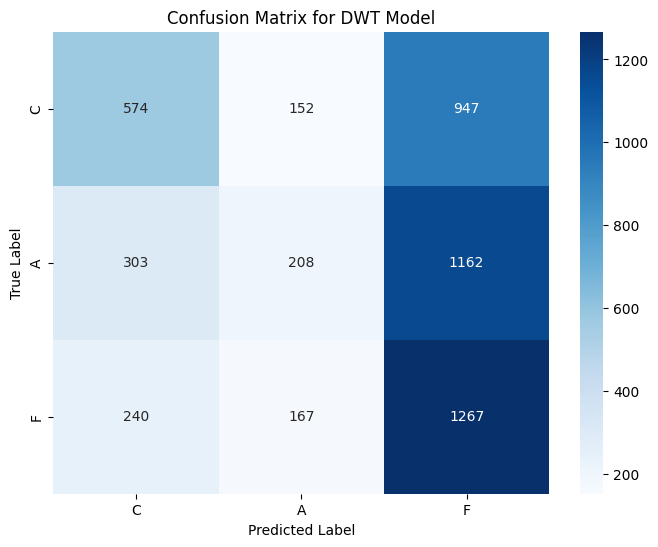

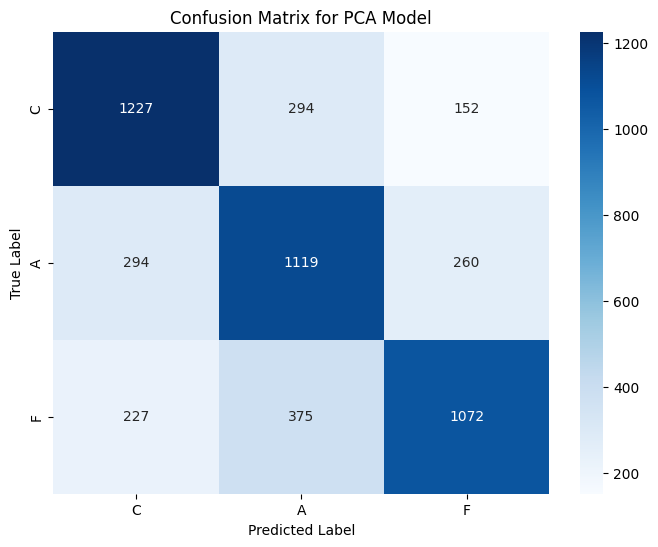

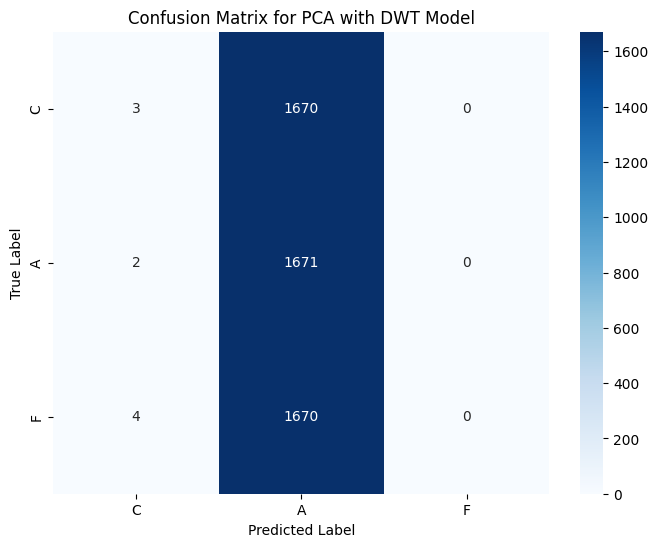


Performing cross-validation for Baseline Model...

Training fold 1...
157/157 [==============================] - 1s 8ms/step
Model for fold 1 saved to /content/drive/MyDrive/Thesis_data/code/baseline_model_fold1.h5

Training fold 2...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 1s 8ms/step
Model for fold 2 saved to /content/drive/MyDrive/Thesis_data/code/baseline_model_fold2.h5

Training fold 3...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 1s 8ms/step
Model for fold 3 saved to /content/drive/MyDrive/Thesis_data/code/baseline_model_fold3.h5

Training fold 4...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 1s 9ms/step
Model for fold 4 saved to /content/drive/MyDrive/Thesis_data/code/baseline_model_fold4.h5

Training fold 5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 1s 8ms/step
Model for fold 5 saved to /content/drive/MyDrive/Thesis_data/code/baseline_model_fold5.h5

Performing cross-validation for DWT Model...

Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 1 saved to /content/drive/MyDrive/Thesis_data/code/dwt_model_fold1.h5

Training fold 2...
157/157 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 2 saved to /content/drive/MyDrive/Thesis_data/code/dwt_model_fold2.h5

Training fold 3...
157/157 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 3 saved to /content/drive/MyDrive/Thesis_data/code/dwt_model_fold3.h5

Training fold 4...
157/157 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 4 saved to /content/drive/MyDrive/Thesis_data/code/dwt_model_fold4.h5

Training fold 5...
157/157 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 5 saved to /content/drive/MyDrive/Thesis_data/code/dwt_model_fold5.h5

Performing cross-validation for PCA Model...

Training fold 1...
157/157 [==============================] - 0s 1ms/step
Model for fold 1 saved to /content/drive/MyDrive/Thesis_data/code/pca_model_fold1.h5

Training fold 2...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 2 saved to /content/drive/MyDrive/Thesis_data/code/pca_model_fold2.h5

Training fold 3...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 3 saved to /content/drive/MyDrive/Thesis_data/code/pca_model_fold3.h5

Training fold 4...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 4 saved to /content/drive/MyDrive/Thesis_data/code/pca_model_fold4.h5

Training fold 5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 5 saved to /content/drive/MyDrive/Thesis_data/code/pca_model_fold5.h5

Performing cross-validation for PCA with DWT Model...

Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 1 saved to /content/drive/MyDrive/Thesis_data/code/pca_dwt_model_fold1.h5

Training fold 2...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 2 saved to /content/drive/MyDrive/Thesis_data/code/pca_dwt_model_fold2.h5

Training fold 3...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 3 saved to /content/drive/MyDrive/Thesis_data/code/pca_dwt_model_fold3.h5

Training fold 4...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 4 saved to /content/drive/MyDrive/Thesis_data/code/pca_dwt_model_fold4.h5

Training fold 5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 0s 1ms/step
Model for fold 5 saved to /content/drive/MyDrive/Thesis_data/code/pca_dwt_model_fold5.h5

Cross-Validation Results for Baseline Model:
Accuracy: 0.5416 ± 0.1712
Sensitivity: 0.5416 ± 0.1712
Specificity: 0.7708 ± 0.0856

Confusion Matrix for Fold 1:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


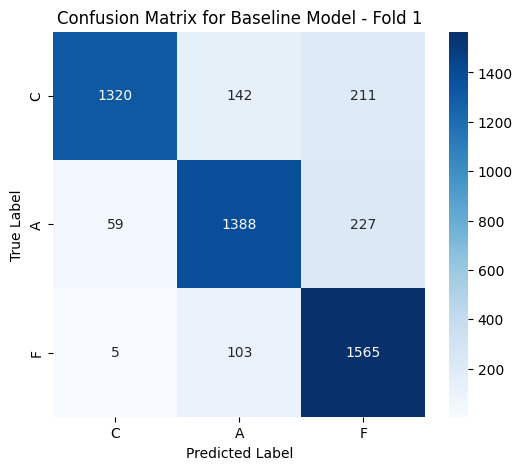


Confusion Matrix for Fold 2:


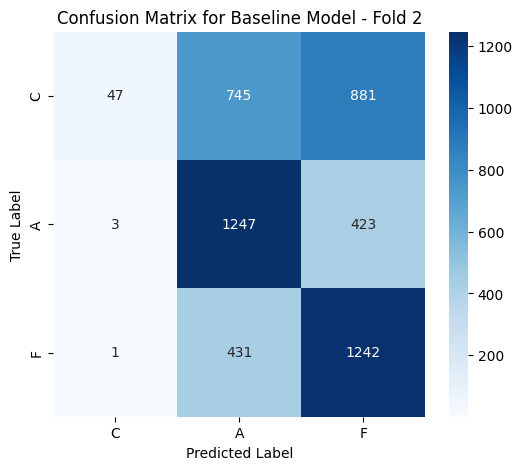


Confusion Matrix for Fold 3:


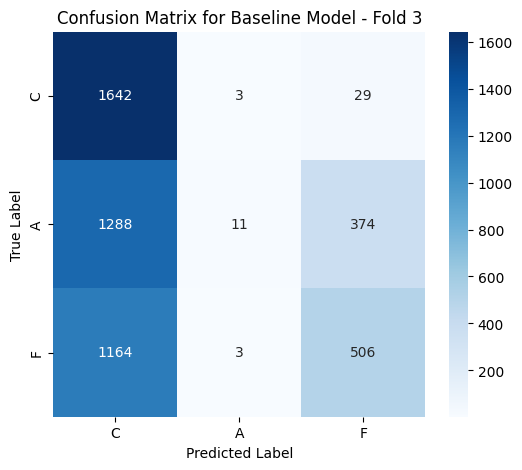


Confusion Matrix for Fold 4:


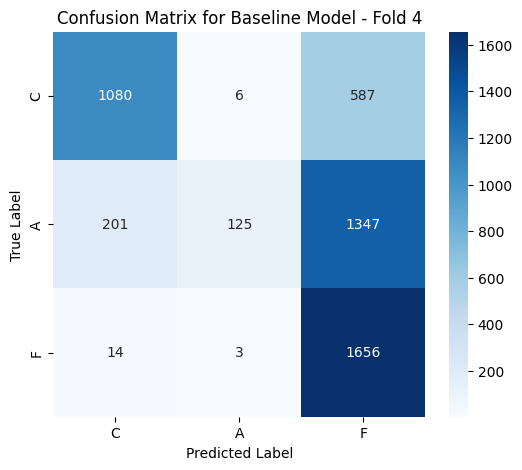


Confusion Matrix for Fold 5:


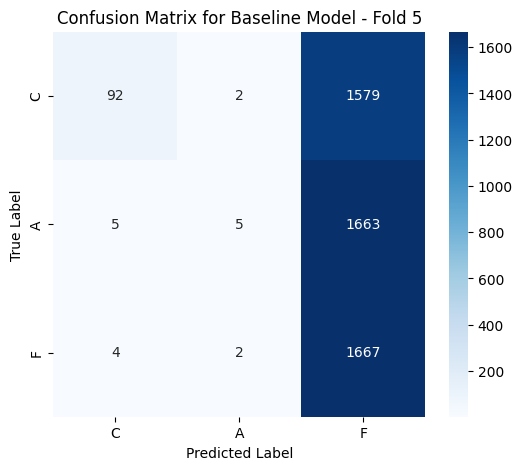


Cross-Validation Results for DWT Model:
Accuracy: 0.3921 ± 0.0124
Sensitivity: 0.3921 ± 0.0124
Specificity: 0.6961 ± 0.0062

Confusion Matrix for Fold 1:


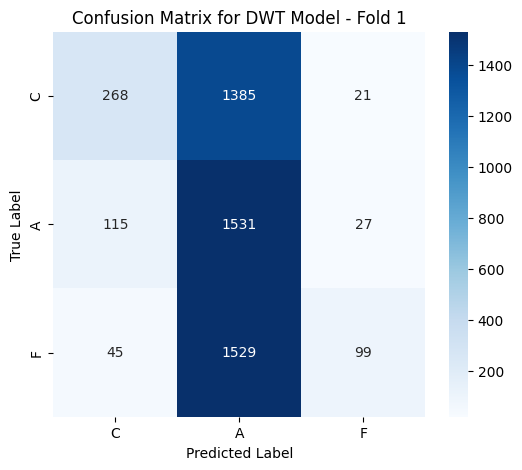


Confusion Matrix for Fold 2:


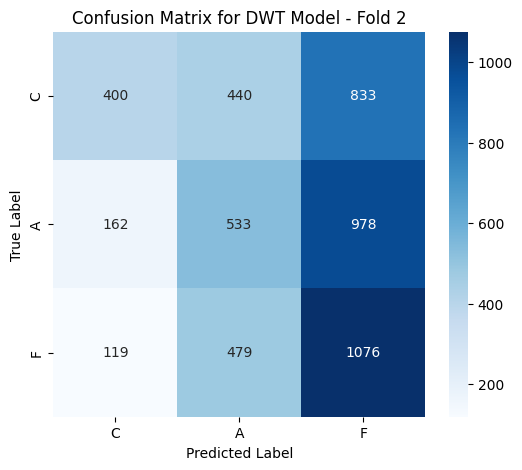


Confusion Matrix for Fold 3:


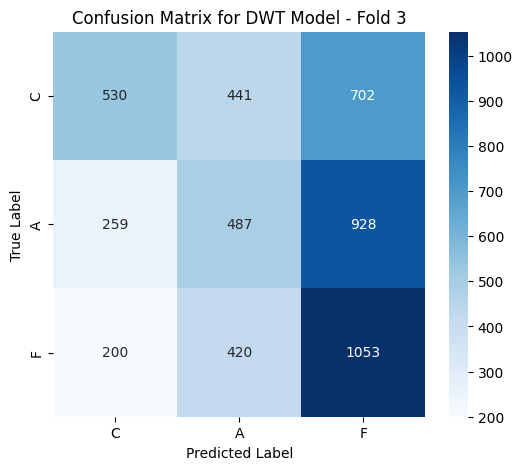


Confusion Matrix for Fold 4:


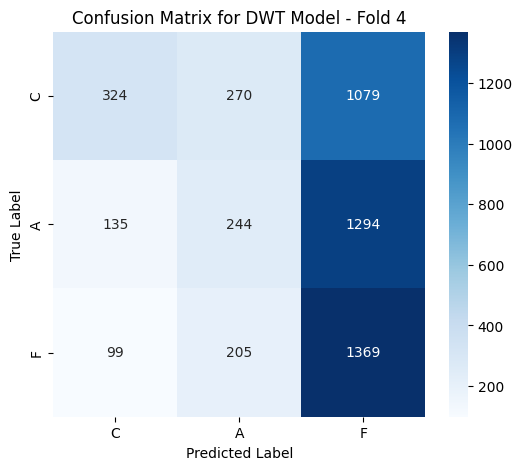


Confusion Matrix for Fold 5:


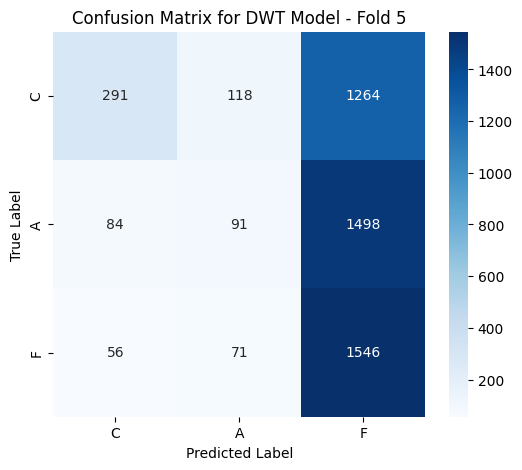


Cross-Validation Results for PCA Model:
Accuracy: 0.6899 ± 0.0046
Sensitivity: 0.6899 ± 0.0046
Specificity: 0.8450 ± 0.0023

Confusion Matrix for Fold 1:


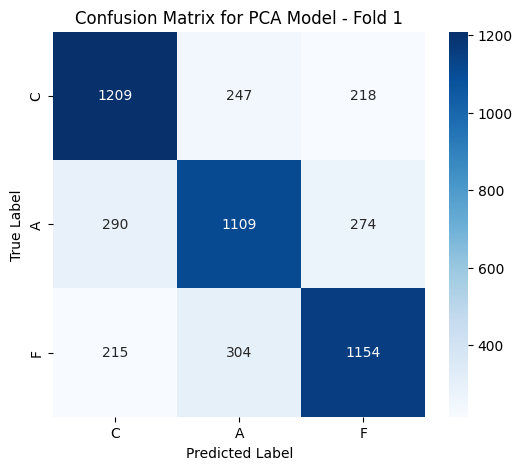


Confusion Matrix for Fold 2:


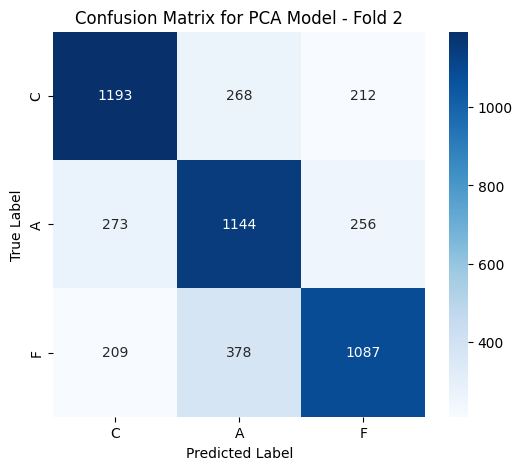


Confusion Matrix for Fold 3:


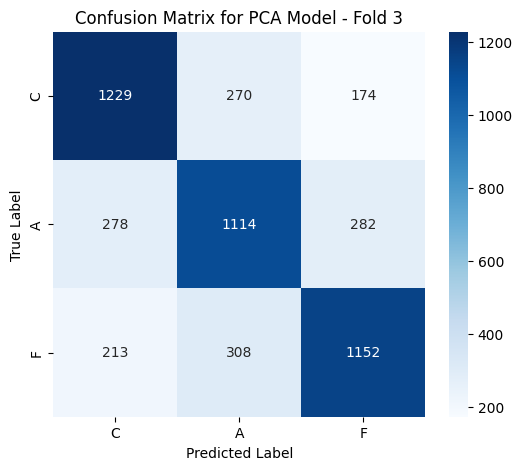


Confusion Matrix for Fold 4:


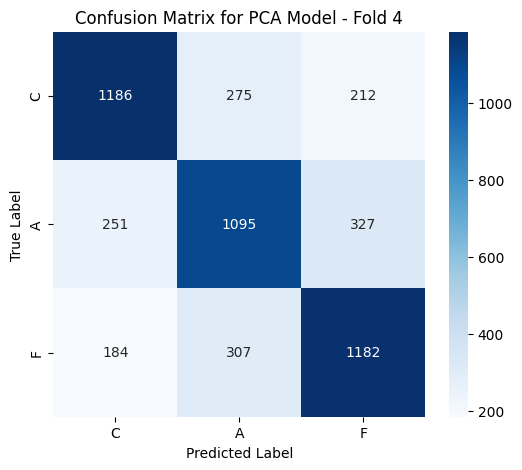


Confusion Matrix for Fold 5:


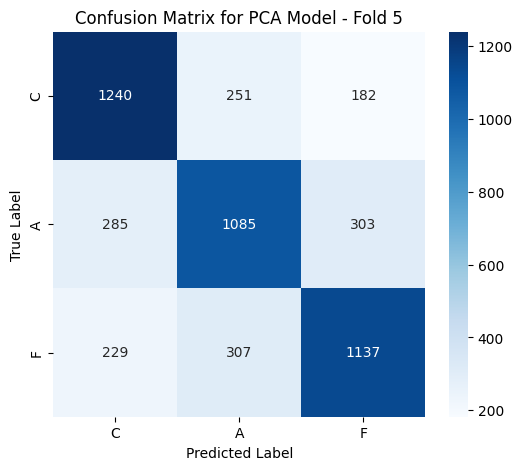


Cross-Validation Results for PCA with DWT Model:
Accuracy: 0.3342 ± 0.0012
Sensitivity: 0.3342 ± 0.0011
Specificity: 0.6671 ± 0.0006

Confusion Matrix for Fold 1:


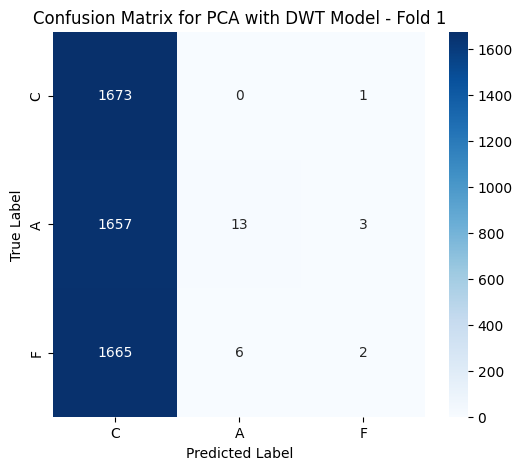


Confusion Matrix for Fold 2:


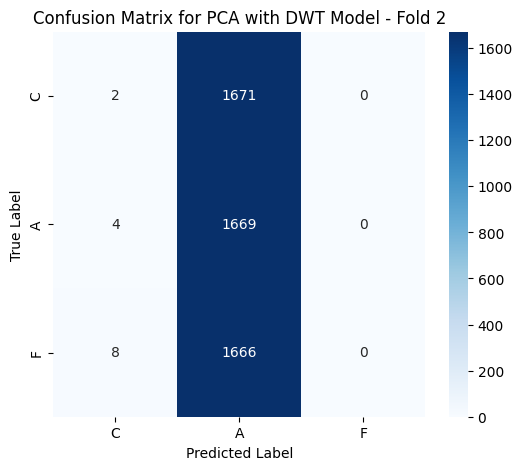


Confusion Matrix for Fold 3:


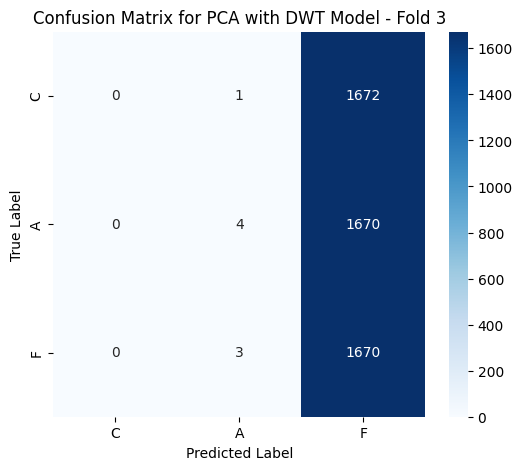


Confusion Matrix for Fold 4:


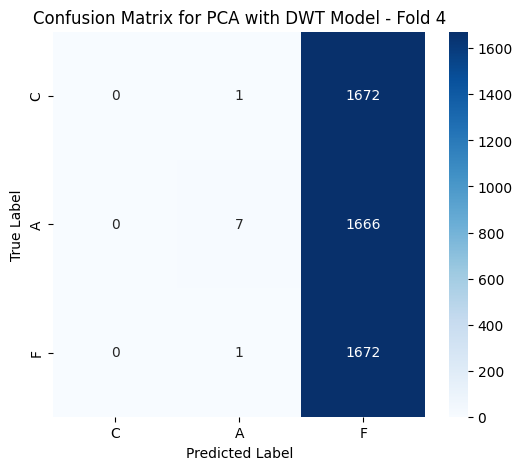


Confusion Matrix for Fold 5:


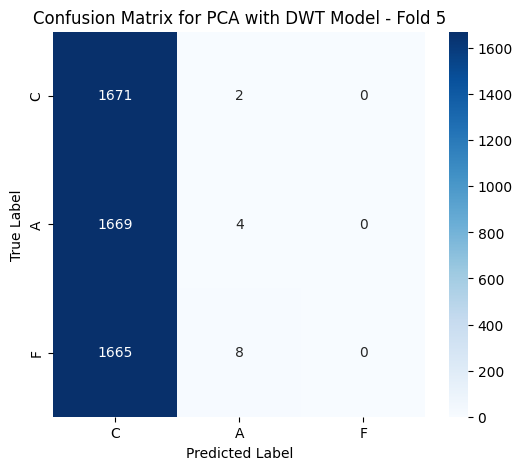


T-test between Baseline and DWT Model: t-statistic=1.7412, p-value=0.1198
T-test between Baseline and PCA Model: t-statistic=-1.7322, p-value=0.1215
T-test between Baseline and PCA with DWT Model: t-statistic=2.4229, p-value=0.0417


In [ ]:
#WITH DWT+ PCA
import os
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import ICA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from scipy.stats import ttest_ind
import pywt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Dense, Flatten, BatchNormalization,
                                     Activation, Dropout)
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import json

# 1. Data Loading

# Update the data path to your dataset directory
data_path = '/content/drive/MyDrive/Thesis_data/unpreprocessed'

# Define the path to save preprocessed data
preprocessed_data_path = '/content/drive/MyDrive/EEGDAT/preprocessed_data'

# Create the directory if it doesn't exist
if not os.path.exists(preprocessed_data_path):
    os.makedirs(preprocessed_data_path)

# Read participants.tsv to get subject IDs and labels
participants_tsv = os.path.join(data_path, '/content/drive/MyDrive/EEGDAT/participants.tsv')
participants_df = pd.read_csv(participants_tsv, sep='\t')

# Map diagnoses to numerical labels using 'Group' column
diagnosis_mapping = {'C': 0, 'A': 1, 'F': 2}
participants_df['label'] = participants_df['Group'].map(diagnosis_mapping)

# Create a dictionary of labels
labels = dict(zip(participants_df['participant_id'], participants_df['label']))

# List of subject IDs
subject_ids = participants_df['participant_id'].tolist()

# Function to get EEG file path
def get_eeg_file(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    eeg_file = None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.set') or file.endswith('_eeg.SET'):
            eeg_file = os.path.join(sub_folder, file)
            break
    if eeg_file is None:
        print(f"No EEG file found in {sub_folder} for subject {sub_id}")
    return eeg_file

# Function to read channel information
def read_channel_info(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    channels_tsv = None
    for file in os.listdir(sub_folder):
        if file.endswith('_channels.tsv') or file.endswith('_CHANNELS.TSV'):
            channels_tsv = os.path.join(sub_folder, file)
            break
    if channels_tsv:
        channels_df = pd.read_csv(channels_tsv, sep='\t')
        return channels_df
    else:
        return None

# Function to read metadata from JSON file
def read_metadata(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    json_file = None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.json') or file.endswith('_EEG.JSON'):
            json_file = os.path.join(sub_folder, file)
            break
    if json_file:
        with open(json_file, 'r') as f:
            metadata = json.load(f)
        return metadata
    else:
        return None

# 2. Preprocessing Functions

def preprocess_eeg(raw, channels_df=None, metadata=None):
    """
    Preprocess the raw EEG data.
    """
    # If channel information is provided, set channel types
    if channels_df is not None:
        ch_names = channels_df['name'].tolist()
        # Convert channel types to lowercase to match MNE's expected types
        ch_types = channels_df['type'].str.lower().tolist()
        mapping = dict(zip(ch_names, ch_types))
        raw.set_channel_types(mapping)

    # Set the EEG montage (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    # Re-reference the data to average of A1 and A2 (if present)
    if 'A1' in raw.ch_names and 'A2' in raw.ch_names:
        raw.set_eeg_reference(['A1', 'A2'])
    else:
        raw.set_eeg_reference('average', projection=False)

    # Band-pass filter (0.5–45 Hz)
    raw.filter(0.5, 45., fir_design='firwin')

    # Independent Component Analysis (ICA) with automatic artifact rejection
    ica = ICA(n_components=15, random_state=97, max_iter='auto')
    ica.fit(raw)

    # Use 'Fp1' and 'Fp2' as proxy EOG channels
    eog_channels = ['Fp1', 'Fp2']
    available_eog_channels = [ch for ch in eog_channels if ch in raw.ch_names]

    if available_eog_channels:
        # Use the available EOG proxy channels for artifact detection
        eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=available_eog_channels)
    else:
        print("No frontal channels available for EOG detection. Proceeding without EOG correction.")
        eog_indices = []

    # Exclude identified EOG components
    ica.exclude.extend(eog_indices)

    # Apply ICA to remove artifacts
    raw = ica.apply(raw)

    # Create fixed-length epochs (e.g., 2 seconds)
    events = mne.make_fixed_length_events(raw, start=0, duration=2.0)
    event_id = {'Rest': 1}

    # Epoching
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Exclude bad epochs
    epochs.drop_bad()

    return epochs

# 3. Feature Extraction Methods

# 3.1 Discrete Wavelet Transform (DWT)
def extract_features_dwt(epochs):
    """
    Extract features using Discrete Wavelet Transform from epochs.
    """
    features = []
    for epoch in epochs.get_data():
        epoch_features = []
        for ch in range(epoch.shape[0]):
            coeffs = pywt.wavedec(epoch[ch, :], 'db4', level=5)
            coeffs_flat = np.hstack(coeffs)
            epoch_features.extend(coeffs_flat)
        features.append(epoch_features)
    return np.array(features)

# 3.2 Principal Component Analysis (PCA) with Cross-Covariance (CCOV)
def extract_features_pca_ccov(epochs):
    """
    Extract features using PCA with Cross-Covariance from epochs.
    """
    features = []
    for epoch in epochs.get_data():
        # Compute cross-covariance matrix
        cov_matrix = np.cov(epoch)
        # Apply PCA
        pca = PCA(n_components=10)  # Adjust the number of components as needed
        pca.fit(cov_matrix)
        epoch_features = pca.components_.flatten()
        features.append(epoch_features)
    return np.array(features)

# 4. EEGNet Model Implementation

def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16,
           norm_rate=0.25, dropoutType='Dropout'):
    """
    EEGNet model as per the original architecture.
    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError("dropoutType must be one of 'Dropout' or 'SpatialDropout2D'")

    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D,
                             use_bias=False, depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classification block
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=tf.keras.constraints.MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    return model

# 5. Data Preparation and Feature Extraction

# Initialize lists to store data and labels
X_baseline = []
y_baseline = []
X_dwt = []
y_dwt = []
X_pca = []
y_pca = []

for sub_id in subject_ids:
    print(f"Processing {sub_id}...")

    # Define the path to the preprocessed data file
    preprocessed_file = os.path.join(preprocessed_data_path, f"{sub_id}_epo.fif")

    if os.path.exists(preprocessed_file):
        # Load preprocessed data
        print(f"Loading preprocessed data for {sub_id}...")
        epochs = mne.read_epochs(preprocessed_file, preload=True)
    else:
        # Get EEG file path
        eeg_file = get_eeg_file(sub_id)
        if eeg_file is None:
            print(f"No EEG file found for {sub_id}. Skipping.")
            continue

        # Load raw EEG data using EEGLAB reader
        try:
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
        except Exception as e:
            print(f"Error loading EEG data for {sub_id}: {e}")
            continue

        # Read channel information
        channels_df = read_channel_info(sub_id)

        # Read metadata (if needed)
        metadata = read_metadata(sub_id)

        # Preprocess the data
        try:
            epochs = preprocess_eeg(raw, channels_df, metadata)
        except Exception as e:
            print(f"Error preprocessing EEG data for {sub_id}: {e}")
            continue

        # Save the preprocessed data
        epochs.save(preprocessed_file, overwrite=True)
        print(f"Preprocessed data saved for {sub_id}.")

    # Get the data from epochs
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    if data.size == 0:
        print(f"No data in epochs for {sub_id}. Skipping.")
        continue

    print(f"Data shape for {sub_id}: {data.shape}")

    # Append to baseline dataset
    X_baseline.extend(data)
    y_baseline.extend([labels[sub_id]] * data.shape[0])

    # Feature Extraction: DWT
    try:
        features_dwt = extract_features_dwt(epochs)
        X_dwt.extend(features_dwt)
        y_dwt.extend([labels[sub_id]] * features_dwt.shape[0])
    except Exception as e:
        print(f"Error in DWT feature extraction for {sub_id}: {e}")
        continue

    # Feature Extraction: PCA with CCOV
    try:
        features_pca = extract_features_pca_ccov(epochs)
        X_pca.extend(features_pca)
        y_pca.extend([labels[sub_id]] * features_pca.shape[0])
    except Exception as e:
        print(f"Error in PCA feature extraction for {sub_id}: {e}")
        continue

# 6. Data Conversion and Balancing

# Convert lists to numpy arrays
X_baseline = np.array(X_baseline)  # Shape: (total_epochs, n_channels, n_times)
y_baseline = np.array(y_baseline)
X_dwt = np.array(X_dwt)
y_dwt = np.array(y_dwt)
X_pca = np.array(X_pca)
y_pca = np.array(y_pca)

# Check if data is loaded
if len(X_baseline) == 0 or len(y_baseline) == 0:
    print("No data was loaded. Please check data loading and preprocessing steps.")
else:
    # Balance the datasets
    from collections import Counter
    from sklearn.utils import resample

    # Function to balance dataset
    def balance_dataset(X, y):
        # Find the unique classes and their counts
        class_counts = Counter(y)
        print(f"Class counts before balancing: {class_counts}")

        # Find the minimum class count
        min_count = min(class_counts.values())
        print(f"Minimum class count: {min_count}")

        # Separate data by class
        classes = np.unique(y)
        X_balanced = []
        y_balanced = []
        for cls in classes:
            idxs = np.where(y == cls)[0]
            X_cls = X[idxs]
            y_cls = y[idxs]
            # Downsample to min_count
            X_cls_downsampled, y_cls_downsampled = resample(
                X_cls, y_cls,
                replace=False,
                n_samples=min_count,
                random_state=42
            )
            X_balanced.append(X_cls_downsampled)
            y_balanced.append(y_cls_downsampled)

        # Concatenate balanced classes
        X_balanced = np.concatenate(X_balanced)
        y_balanced = np.concatenate(y_balanced)

        # Shuffle the data
        idxs = np.arange(len(y_balanced))
        np.random.shuffle(idxs)
        X_balanced = X_balanced[idxs]
        y_balanced = y_balanced[idxs]

        # Print class counts after balancing
        print(f"Class counts after balancing: {Counter(y_balanced)}")

        return X_balanced, y_balanced

    # Balance the datasets
    X_baseline, y_baseline = balance_dataset(X_baseline, y_baseline)
    X_dwt, y_dwt = balance_dataset(X_dwt, y_dwt)
    X_pca, y_pca = balance_dataset(X_pca, y_pca)

    # For EEGNet, reshape data to fit the model input
    X_baseline = X_baseline[..., np.newaxis]  # Shape: (samples, channels, times, 1)

    # Apply PCA to the balanced DWT features
    from sklearn.decomposition import PCA

    def apply_pca(X, n_components=50):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
        return X_pca, pca

    # Apply PCA to X_dwt
    X_pca_dwt, pca_dwt = apply_pca(X_dwt, n_components=50)
    y_pca_dwt = y_dwt  # Labels remain the same

    # One-hot encode the labels for classification
    num_classes = len(np.unique(y_baseline))
    y_baseline_cat = to_categorical(y_baseline, num_classes)
    y_dwt_cat = to_categorical(y_dwt, num_classes)
    y_pca_cat = to_categorical(y_pca, num_classes)
    y_pca_dwt_cat = to_categorical(y_pca_dwt, num_classes)

    # Split the data into training and testing sets
    X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        X_baseline, y_baseline_cat, test_size=0.2, random_state=42, stratify=y_baseline)

    X_train_dwt, X_test_dwt, y_train_dwt, y_test_dwt = train_test_split(
        X_dwt, y_dwt_cat, test_size=0.2, random_state=42, stratify=y_dwt)

    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
        X_pca, y_pca_cat, test_size=0.2, random_state=42, stratify=y_pca)

    X_train_pca_dwt, X_test_pca_dwt, y_train_pca_dwt, y_test_pca_dwt = train_test_split(
        X_pca_dwt, y_pca_dwt_cat, test_size=0.2, random_state=42, stratify=y_pca_dwt)

    # 7. Model Training and Evaluation

    # Create the directory to save models if it doesn't exist
    model_save_path = '/content/drive/MyDrive/Thesis_data/code'
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    # 7.1 Training on Baseline Dataset
    model_base = EEGNet(nb_classes=num_classes, Chans=X_baseline.shape[1], Samples=X_baseline.shape[2])
    model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_base = model_base.fit(X_train_base, y_train_base, epochs=50, batch_size=16,
                                  validation_data=(X_test_base, y_test_base))

    # Save the baseline model
    model_base.save(os.path.join(model_save_path, 'model_base.h5'))
    print("Baseline model saved.")

    # 7.2 Training on DWT Features
    model_dwt = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(X_dwt.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model_dwt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_dwt = model_dwt.fit(X_train_dwt, y_train_dwt, epochs=50, batch_size=16,
                                validation_data=(X_test_dwt, y_test_dwt))

    # Save the DWT model
    model_dwt.save(os.path.join(model_save_path, 'model_dwt.h5'))
    print("DWT model saved.")

    # 7.3 Training on PCA with CCOV Features
    model_pca = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_pca.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model_pca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_pca = model_pca.fit(X_train_pca, y_train_pca, epochs=50, batch_size=16,
                                validation_data=(X_test_pca, y_test_pca))

    # Save the PCA model
    model_pca.save(os.path.join(model_save_path, 'model_pca.h5'))
    print("PCA model saved.")

    # 7.4 Training on PCA with DWT Features
    model_pca_dwt = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_pca_dwt.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model_pca_dwt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_pca_dwt = model_pca_dwt.fit(X_train_pca_dwt, y_train_pca_dwt, epochs=50, batch_size=16,
                                        validation_data=(X_test_pca_dwt, y_test_pca_dwt))

    # Save the PCA with DWT model
    model_pca_dwt.save(os.path.join(model_save_path, 'model_pca_dwt.h5'))
    print("PCA with DWT model saved.")

    # 8. Evaluation Metrics

    # Function to calculate evaluation metrics
    def evaluate_model(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        sensitivity = recall_score(y_true, y_pred, average='macro')
        # Specificity calculation for multiclass
        specificity = []
        for i in range(num_classes):
            tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
            fp = np.sum(np.delete(cm[:, i], i))
            specificity.append(tn / (tn + fp))
        specificity = np.mean(specificity)
        return acc, sensitivity, specificity, cm

    # Predict on the test sets
    y_pred_base = model_base.predict(X_test_base)
    y_pred_dwt = model_dwt.predict(X_test_dwt)
    y_pred_pca = model_pca.predict(X_test_pca)
    y_pred_pca_dwt = model_pca_dwt.predict(X_test_pca_dwt)

    # Convert predictions and true labels to class labels
    y_pred_base_cls = np.argmax(y_pred_base, axis=1)
    y_true_base_cls = np.argmax(y_test_base, axis=1)

    y_pred_dwt_cls = np.argmax(y_pred_dwt, axis=1)
    y_true_dwt_cls = np.argmax(y_test_dwt, axis=1)

    y_pred_pca_cls = np.argmax(y_pred_pca, axis=1)
    y_true_pca_cls = np.argmax(y_test_pca, axis=1)

    y_pred_pca_dwt_cls = np.argmax(y_pred_pca_dwt, axis=1)
    y_true_pca_dwt_cls = np.argmax(y_test_pca_dwt, axis=1)

    # Evaluate models
    acc_base, sens_base, spec_base, cm_base = evaluate_model(y_true_base_cls, y_pred_base_cls)
    acc_dwt, sens_dwt, spec_dwt, cm_dwt = evaluate_model(y_true_dwt_cls, y_pred_dwt_cls)
    acc_pca, sens_pca, spec_pca, cm_pca = evaluate_model(y_true_pca_cls, y_pred_pca_cls)
    acc_pca_dwt, sens_pca_dwt, spec_pca_dwt, cm_pca_dwt = evaluate_model(y_true_pca_dwt_cls, y_pred_pca_dwt_cls)

    # Print the results
    print(f"Baseline Model - Accuracy: {acc_base:.4f}, Sensitivity: {sens_base:.4f}, Specificity: {spec_base:.4f}")
    print(f"DWT Model - Accuracy: {acc_dwt:.4f}, Sensitivity: {sens_dwt:.4f}, Specificity: {spec_dwt:.4f}")
    print(f"PCA Model - Accuracy: {acc_pca:.4f}, Sensitivity: {sens_pca:.4f}, Specificity: {spec_pca:.4f}")
    print(f"PCA with DWT Model - Accuracy: {acc_pca_dwt:.4f}, Sensitivity: {sens_pca_dwt:.4f}, Specificity: {spec_pca_dwt:.4f}")

    # Define class labels
    class_labels = ['C', 'A', 'F']  # Adjust labels according to your mapping

    # Plot confusion matrices
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Function to plot confusion matrix
    def plot_confusion_matrix(cm, model_name):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    # Plot confusion matrices for each model
    plot_confusion_matrix(cm_base, 'Baseline Model')
    plot_confusion_matrix(cm_dwt, 'DWT Model')
    plot_confusion_matrix(cm_pca, 'PCA Model')
    plot_confusion_matrix(cm_pca_dwt, 'PCA with DWT Model')

    # 9. Cross-Validation with Detailed Metrics

    # Ensure the model save path exists
    model_save_path = '/content/drive/MyDrive/Thesis_data/code'
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    # Updated cross_val_evaluate function
    def cross_val_evaluate(model_func, X, y, model_name_prefix, epochs=50, batch_size=16):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = []
        sensitivities = []
        specificities = []
        confusion_matrices = []
        fold_number = 1
        for train_index, test_index in skf.split(X, np.argmax(y, axis=1)):
            print(f"\nTraining fold {fold_number}...")
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            model = model_func()
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
            y_pred_fold = model.predict(X_test_fold)
            y_pred_cls = np.argmax(y_pred_fold, axis=1)
            y_true_cls = np.argmax(y_test_fold, axis=1)

            # Calculate evaluation metrics
            acc, sens, spec, cm = evaluate_model(y_true_cls, y_pred_cls)
            accuracies.append(acc)
            sensitivities.append(sens)
            specificities.append(spec)
            confusion_matrices.append(cm)

            # Save the model for this fold
            model_save_path_fold = os.path.join(model_save_path, f"{model_name_prefix}_fold{fold_number}.h5")
            model.save(model_save_path_fold)
            print(f"Model for fold {fold_number} saved to {model_save_path_fold}")

            fold_number += 1
        return {
            'accuracies': np.array(accuracies),
            'sensitivities': np.array(sensitivities),
            'specificities': np.array(specificities),
            'confusion_matrices': confusion_matrices
        }

    # Define model creation functions
    def create_eegnet_model():
        return EEGNet(nb_classes=num_classes, Chans=X_baseline.shape[1], Samples=X_baseline.shape[2])

    def create_dwt_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu', input_shape=(X_dwt.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

    def create_pca_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(X_pca.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

    def create_pca_dwt_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(X_pca_dwt.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

    # Perform cross-validation and save models
    print("\nPerforming cross-validation for Baseline Model...")
    cv_results_base = cross_val_evaluate(create_eegnet_model, X_baseline, y_baseline_cat, 'baseline_model')

    print("\nPerforming cross-validation for DWT Model...")
    cv_results_dwt = cross_val_evaluate(create_dwt_model, X_dwt, y_dwt_cat, 'dwt_model')

    print("\nPerforming cross-validation for PCA Model...")
    cv_results_pca = cross_val_evaluate(create_pca_model, X_pca, y_pca_cat, 'pca_model')

    print("\nPerforming cross-validation for PCA with DWT Model...")
    cv_results_pca_dwt = cross_val_evaluate(create_pca_dwt_model, X_pca_dwt, y_pca_dwt_cat, 'pca_dwt_model')

    # Function to display cross-validation metrics
    def display_cv_metrics(cv_results, model_name):
        accuracies = cv_results['accuracies']
        sensitivities = cv_results['sensitivities']
        specificities = cv_results['specificities']
        confusion_matrices = cv_results['confusion_matrices']

        print(f"\nCross-Validation Results for {model_name}:")
        print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
        print(f"Sensitivity: {np.mean(sensitivities):.4f} ± {np.std(sensitivities):.4f}")
        print(f"Specificity: {np.mean(specificities):.4f} ± {np.std(specificities):.4f}")

        # Optionally, display confusion matrices for each fold
        for i, cm in enumerate(confusion_matrices):
            print(f"\nConfusion Matrix for Fold {i+1}:")
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_labels, yticklabels=class_labels)
            plt.title(f'Confusion Matrix for {model_name} - Fold {i+1}')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

    # Display metrics for each model
    display_cv_metrics(cv_results_base, 'Baseline Model')
    display_cv_metrics(cv_results_dwt, 'DWT Model')
    display_cv_metrics(cv_results_pca, 'PCA Model')
    display_cv_metrics(cv_results_pca_dwt, 'PCA with DWT Model')

    # Perform t-tests on accuracies
    t_stat_dwt, p_value_dwt = ttest_ind(cv_results_base['accuracies'], cv_results_dwt['accuracies'])
    t_stat_pca, p_value_pca = ttest_ind(cv_results_base['accuracies'], cv_results_pca['accuracies'])
    t_stat_pca_dwt, p_value_pca_dwt = ttest_ind(cv_results_base['accuracies'], cv_results_pca_dwt['accuracies'])

    print(f"\nT-test between Baseline and DWT Model: t-statistic={t_stat_dwt:.4f}, p-value={p_value_dwt:.4f}")
    print(f"T-test between Baseline and PCA Model: t-statistic={t_stat_pca:.4f}, p-value={p_value_pca:.4f}")
    print(f"T-test between Baseline and PCA with DWT Model: t-statistic={t_stat_pca_dwt:.4f}, p-value={p_value_pca_dwt:.4f}")


Processing sub-001...
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 299 events and 1001 original time points ...
0 bad epochs dropped
Data shape for sub-001: (299, 19, 1001)
Processing sub-002...
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 396 events and 1001 original time points ...
0 bad epochs dropped
Data shape for sub-002: (396, 19, 1001)
Processing sub-003...
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 1001 original time points ...
0 bad epochs dropped
Data shape for sub-003: (153, 19, 1001)
Processing sub-004...
Not setting metadata
353 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 353 events and 1001 original t

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 1 saved to /content/drive/MyDrive/Thesis_data/code/eegnet_raw_model_fold1.h5

Training fold 2...
Epoch 1/50
1255/1255 [==============================] - 65s 51ms/step - loss: 1.0465 - accuracy: 0.4430
Epoch 2/50
1255/1255 [==============================] - 64s 51ms/step - loss: 1.0054 - accuracy: 0.4817
Epoch 3/50
1255/1255 [==============================] - 64s 51ms/step - loss: 0.9803 - accuracy: 0.5088
Epoch 4/50
1255/1255 [==============================] - 64s 51ms/step - loss: 0.9529 - accuracy: 0.5263
Epoch 5/50
1255/1255 [==============================] - 65s 52ms/step - loss: 0.9364 - accuracy: 0.5432
Epoch 6/50
1255/1255 [==============================] - 65s 52ms/step - loss: 0.9174 - accuracy: 0.5613
Epoch 7/50
1255/1255 [==============================] - 64s 51ms/step - loss: 0.9064 - accuracy: 0.5697
Epoch 8/50
1255/1255 [==============================] - 64s 51ms/step - loss: 0.8925 - accuracy: 0.5755
Epoch 9/50
1255/1255 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 2 saved to /content/drive/MyDrive/Thesis_data/code/eegnet_raw_model_fold2.h5

Training fold 3...
Epoch 1/50
1255/1255 [==============================] - 63s 49ms/step - loss: 1.0303 - accuracy: 0.4596
Epoch 2/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.9778 - accuracy: 0.5079
Epoch 3/50
1255/1255 [==============================] - 62s 49ms/step - loss: 0.9559 - accuracy: 0.5313
Epoch 4/50
1255/1255 [==============================] - 62s 49ms/step - loss: 0.9341 - accuracy: 0.5412
Epoch 5/50
1255/1255 [==============================] - 62s 49ms/step - loss: 0.9245 - accuracy: 0.5519
Epoch 6/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.9059 - accuracy: 0.5669
Epoch 7/50
1255/1255 [==============================] - 62s 49ms/step - loss: 0.8922 - accuracy: 0.5775
Epoch 8/50
1255/1255 [==============================] - 63s 50ms/step - loss: 0.8758 - accuracy: 0.5860
Epoch 9/50
1255/1255 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 3 saved to /content/drive/MyDrive/Thesis_data/code/eegnet_raw_model_fold3.h5

Training fold 4...
Epoch 1/50
1255/1255 [==============================] - 63s 50ms/step - loss: 1.0440 - accuracy: 0.4368
Epoch 2/50
1255/1255 [==============================] - 62s 49ms/step - loss: 0.9737 - accuracy: 0.5100
Epoch 3/50
1255/1255 [==============================] - 63s 50ms/step - loss: 0.9537 - accuracy: 0.5275
Epoch 4/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.9336 - accuracy: 0.5410
Epoch 5/50
1255/1255 [==============================] - 63s 50ms/step - loss: 0.9183 - accuracy: 0.5564
Epoch 6/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.9063 - accuracy: 0.5644
Epoch 7/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.8946 - accuracy: 0.5780
Epoch 8/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.8832 - accuracy: 0.5868
Epoch 9/50
1255/1255 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 4 saved to /content/drive/MyDrive/Thesis_data/code/eegnet_raw_model_fold4.h5

Training fold 5...
Epoch 1/50
1255/1255 [==============================] - 64s 50ms/step - loss: 1.0310 - accuracy: 0.4514
Epoch 2/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.9889 - accuracy: 0.4974
Epoch 3/50
1255/1255 [==============================] - 62s 50ms/step - loss: 0.9586 - accuracy: 0.5284
Epoch 4/50
1255/1255 [==============================] - 63s 50ms/step - loss: 0.9431 - accuracy: 0.5352
Epoch 5/50
1255/1255 [==============================] - 63s 50ms/step - loss: 0.9297 - accuracy: 0.5503
Epoch 6/50
1255/1255 [==============================] - 62s 49ms/step - loss: 0.9148 - accuracy: 0.5622
Epoch 7/50
1255/1255 [==============================] - 63s 50ms/step - loss: 0.9071 - accuracy: 0.5669
Epoch 8/50
1255/1255 [==============================] - 63s 50ms/step - loss: 0.8898 - accuracy: 0.5794
Epoch 9/50
1255/1255 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 5 saved to /content/drive/MyDrive/Thesis_data/code/eegnet_raw_model_fold5.h5

Cross-Validation Results for EEGNet Model on Unpreprocessed Data:
Accuracy: 0.5794 ± 0.0846
Sensitivity: 0.5794 ± 0.0846
Specificity: 0.7897 ± 0.0423

Confusion Matrix for Fold 1:


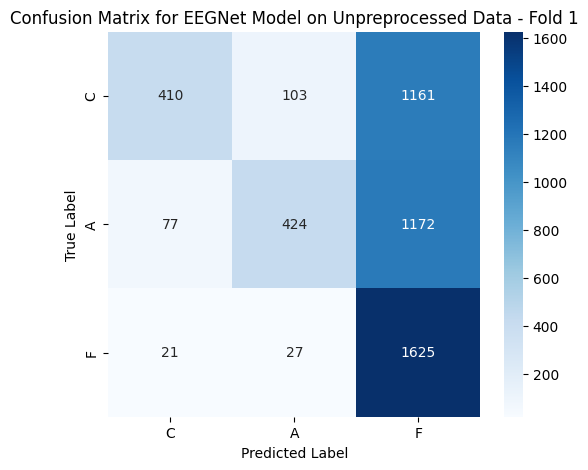


Confusion Matrix for Fold 2:


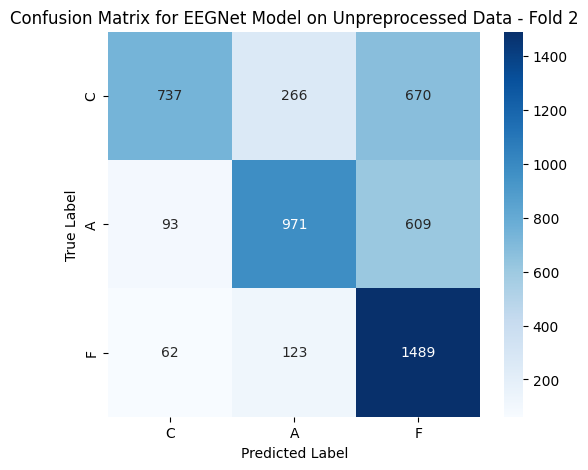


Confusion Matrix for Fold 3:


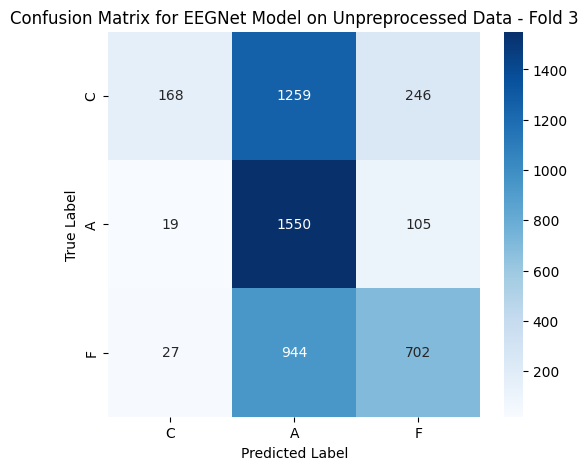


Confusion Matrix for Fold 4:


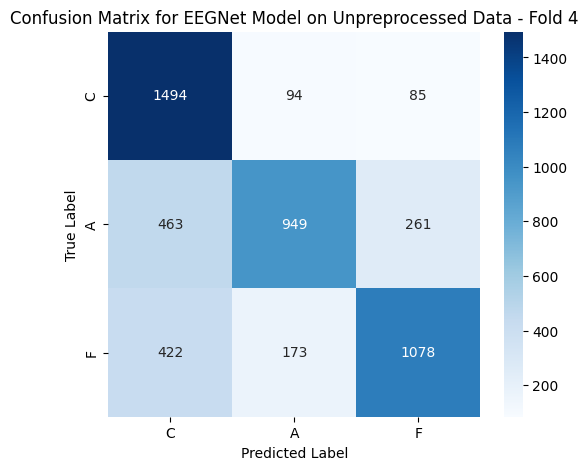


Confusion Matrix for Fold 5:


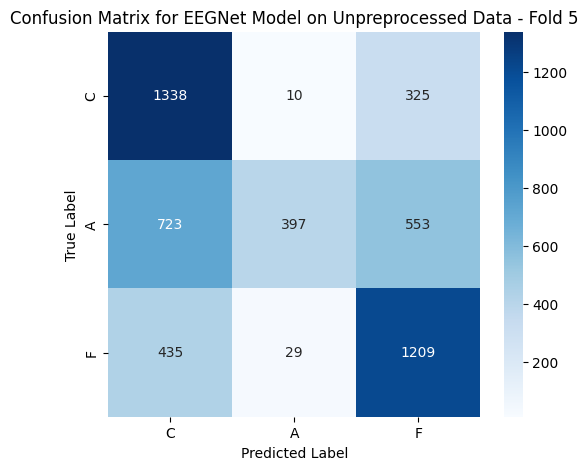

In [ ]:
# Unpreproccessed
import os
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Dense, Flatten, BatchNormalization,
                                     Activation, Dropout)
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.utils import resample

# 1. Data Loading

# Update the data path to your dataset directory
data_path = '/content/drive/MyDrive/Thesis_data/unpreprocessed'

# Read participants.tsv to get subject IDs and labels
participants_tsv = os.path.join(data_path, '/content/drive/MyDrive/EEGDAT/participants.tsv')
participants_df = pd.read_csv(participants_tsv, sep='\t')

# Map diagnoses to numerical labels using 'Group' column
diagnosis_mapping = {'C': 0, 'A': 1, 'F': 2}
participants_df['label'] = participants_df['Group'].map(diagnosis_mapping)

# Create a dictionary of labels
labels = dict(zip(participants_df['participant_id'], participants_df['label']))

# List of subject IDs
subject_ids = participants_df['participant_id'].tolist()

# Function to get EEG file path
def get_eeg_file(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    eeg_file = None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.set') or file.endswith('_eeg.SET'):
            eeg_file = os.path.join(sub_folder, file)
            break
    if eeg_file is None:
        print(f"No EEG file found in {sub_folder} for subject {sub_id}")
    return eeg_file

# Function to read channel information
def read_channel_info(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    channels_tsv = None
    for file in os.listdir(sub_folder):
        if file.endswith('_channels.tsv') or file.endswith('_CHANNELS.TSV'):
            channels_tsv = os.path.join(sub_folder, file)
            break
    if channels_tsv:
        channels_df = pd.read_csv(channels_tsv, sep='\t')
        return channels_df
    else:
        return None

# Function to load raw EEG data without preprocessing
def load_raw_eeg(sub_id):
    eeg_file = get_eeg_file(sub_id)
    if eeg_file is None:
        print(f"No EEG file found for {sub_id}. Skipping.")
        return None

    # Load raw EEG data using EEGLAB reader
    try:
        raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
    except Exception as e:
        print(f"Error loading EEG data for {sub_id}: {e}")
        return None

    return raw

# 2. EEGNet Model Implementation

def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16,
           norm_rate=0.25, dropoutType='Dropout'):
    """
    EEGNet model as per the original architecture.
    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError("dropoutType must be one of 'Dropout' or 'SpatialDropout2D'")

    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D,
                             use_bias=False, depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classification block
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=tf.keras.constraints.MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    return model

# 3. Data Preparation

# Initialize lists to store data and labels for raw data
X_raw = []
y_raw = []

for sub_id in subject_ids:
    print(f"Processing {sub_id}...")

    # Load raw EEG data without preprocessing
    raw = load_raw_eeg(sub_id)
    if raw is None:
        continue

    # Optional: Set channel types if necessary
    channels_df = read_channel_info(sub_id)
    if channels_df is not None:
        ch_names = channels_df['name'].tolist()
        ch_types = channels_df['type'].str.lower().tolist()
        mapping = dict(zip(ch_names, ch_types))
        raw.set_channel_types(mapping)

    # Get data from raw object
    data = raw.get_data()  # Shape: (n_channels, n_times)

    # Since EEGNet expects epochs, we need to create epochs from the raw data
    # We'll create fixed-length epochs without any event-related processing

    # Create fixed-length epochs (e.g., 2 seconds)
    events = mne.make_fixed_length_events(raw, start=0, duration=2.0)
    event_id = {'Rest': 1}

    # Epoching
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Get the data from epochs
    data_epochs = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    if data_epochs.size == 0:
        print(f"No data in epochs for {sub_id}. Skipping.")
        continue

    print(f"Data shape for {sub_id}: {data_epochs.shape}")

    # Append to raw dataset
    X_raw.extend(data_epochs)
    y_raw.extend([labels[sub_id]] * data_epochs.shape[0])

# 4. Data Conversion and Balancing

# Convert lists to numpy arrays
X_raw = np.array(X_raw)  # Shape: (total_epochs, n_channels, n_times)
y_raw = np.array(y_raw)

# Balance the dataset
def balance_dataset(X, y):
    # Find the unique classes and their counts
    class_counts = Counter(y)
    print(f"Class counts before balancing: {class_counts}")

    # Find the minimum class count
    min_count = min(class_counts.values())
    print(f"Minimum class count: {min_count}")

    # Separate data by class
    classes = np.unique(y)
    X_balanced = []
    y_balanced = []
    for cls in classes:
        idxs = np.where(y == cls)[0]
        X_cls = X[idxs]
        y_cls = y[idxs]
        # Downsample to min_count
        X_cls_downsampled, y_cls_downsampled = resample(
            X_cls, y_cls,
            replace=False,
            n_samples=min_count,
            random_state=42
        )
        X_balanced.append(X_cls_downsampled)
        y_balanced.append(y_cls_downsampled)

    # Concatenate balanced classes
    X_balanced = np.concatenate(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    # Shuffle the data
    idxs = np.arange(len(y_balanced))
    np.random.shuffle(idxs)
    X_balanced = X_balanced[idxs]
    y_balanced = y_balanced[idxs]

    # Print class counts after balancing
    print(f"Class counts after balancing: {Counter(y_balanced)}")

    return X_balanced, y_balanced

# Balance the dataset
X_raw, y_raw = balance_dataset(X_raw, y_raw)

# Reshape data to fit the model input
X_raw = X_raw[..., np.newaxis]  # Shape: (samples, channels, times, 1)

# One-hot encode the labels
num_classes = len(np.unique(y_raw))
y_raw_cat = to_categorical(y_raw, num_classes)

# Split the data into training and testing sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw_cat, test_size=0.2, random_state=42, stratify=y_raw)

# 5. Model Training

# Create the directory to save models if it doesn't exist
model_save_path = '/content/drive/MyDrive/Thesis_data/code'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Create a new EEGNet model
model_raw = EEGNet(nb_classes=num_classes, Chans=X_raw.shape[1], Samples=X_raw.shape[2])

# Compile the model
model_raw.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_raw = model_raw.fit(X_train_raw, y_train_raw, epochs=50, batch_size=16,
                            validation_data=(X_test_raw, y_test_raw))

# Save the model
model_raw.save(os.path.join(model_save_path, 'model_raw.h5'))
print("EEGNet model trained on unpreprocessed data saved.")

# 6. Evaluation Metrics

# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average='macro')
    # Specificity calculation for multiclass
    specificity = []
    for i in range(num_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp))
    specificity = np.mean(specificity)
    return acc, sensitivity, specificity, cm

# Predict on the test set
y_pred_raw = model_raw.predict(X_test_raw)

# Convert predictions and true labels to class labels
y_pred_raw_cls = np.argmax(y_pred_raw, axis=1)
y_true_raw_cls = np.argmax(y_test_raw, axis=1)

# Evaluate the model
acc_raw, sens_raw, spec_raw, cm_raw = evaluate_model(y_true_raw_cls, y_pred_raw_cls)

# Print the results
print(f"EEGNet Model on Unpreprocessed Data - Accuracy: {acc_raw:.4f}, Sensitivity: {sens_raw:.4f}, Specificity: {spec_raw:.4f}")

# 7. Visualization

# Define class labels (adjust according to your mapping)
class_labels = ['C', 'A', 'F']

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm_raw, 'EEGNet Model on Unpreprocessed Data')

# Import necessary libraries
import os
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Dense, Flatten, BatchNormalization,
                                     Activation, Dropout)
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.utils import resample

# 1. Data Loading

# Update the data path to your dataset directory
data_path = '/content/drive/MyDrive/Thesis_data/unpreprocessed'

# Read participants.tsv to get subject IDs and labels
participants_tsv = os.path.join(data_path, '/content/drive/MyDrive/EEGDAT/participants.tsv')
participants_df = pd.read_csv(participants_tsv, sep='\t')

# Map diagnoses to numerical labels using 'Group' column
diagnosis_mapping = {'C': 0, 'A': 1, 'F': 2}
participants_df['label'] = participants_df['Group'].map(diagnosis_mapping)

# Create a dictionary of labels
labels = dict(zip(participants_df['participant_id'], participants_df['label']))

# List of subject IDs
subject_ids = participants_df['participant_id'].tolist()

# Function to get EEG file path
def get_eeg_file(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    eeg_file = None
    if not os.path.exists(sub_folder):
        print(f"Directory {sub_folder} does not exist for subject {sub_id}")
        return None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.set') or file.endswith('_eeg.SET'):
            eeg_file = os.path.join(sub_folder, file)
            break
    if eeg_file is None:
        print(f"No EEG file found in {sub_folder} for subject {sub_id}")
    return eeg_file

# Function to read channel information
def read_channel_info(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    channels_tsv = None
    if not os.path.exists(sub_folder):
        return None
    for file in os.listdir(sub_folder):
        if file.endswith('_channels.tsv') or file.endswith('_CHANNELS.TSV'):
            channels_tsv = os.path.join(sub_folder, file)
            break
    if channels_tsv:
        channels_df = pd.read_csv(channels_tsv, sep='\t')
        return channels_df
    else:
        return None

# Function to load raw EEG data without preprocessing
def load_raw_eeg(sub_id):
    eeg_file = get_eeg_file(sub_id)
    if eeg_file is None:
        print(f"No EEG file found for {sub_id}. Skipping.")
        return None

    # Load raw EEG data using EEGLAB reader
    try:
        raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
    except Exception as e:
        print(f"Error loading EEG data for {sub_id}: {e}")
        return None

    return raw

# 2. EEGNet Model Implementation

def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16,
           norm_rate=0.25, dropoutType='Dropout'):
    """
    EEGNet model as per the original architecture.
    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError("dropoutType must be one of 'Dropout' or 'SpatialDropout2D'")

    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D,
                             use_bias=False, depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classification block
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=tf.keras.constraints.MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    return model

# 3. Data Preparation

# Initialize lists to store data and labels for raw data
X_raw = []
y_raw = []

for sub_id in subject_ids:
    print(f"Processing {sub_id}...")

    # Load raw EEG data without preprocessing
    raw = load_raw_eeg(sub_id)
    if raw is None:
        continue

    # Optional: Set channel types if necessary
    channels_df = read_channel_info(sub_id)
    if channels_df is not None:
        ch_names = channels_df['name'].tolist()
        ch_types = channels_df['type'].str.lower().tolist()
        mapping = dict(zip(ch_names, ch_types))
        raw.set_channel_types(mapping)

    # Get data from raw object
    data = raw.get_data()  # Shape: (n_channels, n_times)

    # Since EEGNet expects epochs, we need to create epochs from the raw data
    # We'll create fixed-length epochs without any event-related processing

    # Create fixed-length epochs (e.g., 2 seconds)
    events = mne.make_fixed_length_events(raw, start=0, duration=2.0)
    event_id = {'Rest': 1}

    # Epoching
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Get the data from epochs
    data_epochs = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    if data_epochs.size == 0:
        print(f"No data in epochs for {sub_id}. Skipping.")
        continue

    print(f"Data shape for {sub_id}: {data_epochs.shape}")

    # Append to raw dataset
    X_raw.extend(data_epochs)
    y_raw.extend([labels[sub_id]] * data_epochs.shape[0])

# 4. Data Conversion and Balancing

# Convert lists to numpy arrays
X_raw = np.array(X_raw)  # Shape: (total_epochs, n_channels, n_times)
y_raw = np.array(y_raw)

# Balance the dataset
def balance_dataset(X, y):
    # Find the unique classes and their counts
    class_counts = Counter(y)
    print(f"Class counts before balancing: {class_counts}")

    # Find the minimum class count
    min_count = min(class_counts.values())
    print(f"Minimum class count: {min_count}")

    # Separate data by class
    classes = np.unique(y)
    X_balanced = []
    y_balanced = []
    for cls in classes:
        idxs = np.where(y == cls)[0]
        X_cls = X[idxs]
        y_cls = y[idxs]
        # Downsample to min_count
        X_cls_downsampled, y_cls_downsampled = resample(
            X_cls, y_cls,
            replace=False,
            n_samples=min_count,
            random_state=42
        )
        X_balanced.append(X_cls_downsampled)
        y_balanced.append(y_cls_downsampled)

    # Concatenate balanced classes
    X_balanced = np.concatenate(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    # Shuffle the data
    idxs = np.arange(len(y_balanced))
    np.random.shuffle(idxs)
    X_balanced = X_balanced[idxs]
    y_balanced = y_balanced[idxs]

    # Print class counts after balancing
    print(f"Class counts after balancing: {Counter(y_balanced)}")

    return X_balanced, y_balanced

# Balance the dataset
X_raw, y_raw = balance_dataset(X_raw, y_raw)

# Reshape data to fit the model input
X_raw = X_raw[..., np.newaxis]  # Shape: (samples, channels, times, 1)

# One-hot encode the labels
num_classes = len(np.unique(y_raw))
y_raw_cat = to_categorical(y_raw, num_classes)

# 5. Cross-Validation and Model Training

# Create the directory to save models if it doesn't exist
model_save_path = '/content/drive/MyDrive/Thesis_data/code'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average='macro')
    # Specificity calculation for multiclass
    specificity = []
    for i in range(num_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp))
    specificity = np.mean(specificity)
    return acc, sensitivity, specificity, cm

# Cross-Validation Function
def cross_val_evaluate(model_func, X, y, model_name_prefix, epochs=50, batch_size=16):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    sensitivities = []
    specificities = []
    confusion_matrices = []
    fold_number = 1
    for train_index, test_index in skf.split(X, np.argmax(y, axis=1)):
        print(f"\nTraining fold {fold_number}...")
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model = model_func()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=1)
        y_pred_fold = model.predict(X_test_fold)
        y_pred_cls = np.argmax(y_pred_fold, axis=1)
        y_true_cls = np.argmax(y_test_fold, axis=1)

        # Calculate evaluation metrics
        acc, sens, spec, cm = evaluate_model(y_true_cls, y_pred_cls)
        accuracies.append(acc)
        sensitivities.append(sens)
        specificities.append(spec)
        confusion_matrices.append(cm)

        # Save the model for this fold
        model_save_path_fold = os.path.join(model_save_path, f"{model_name_prefix}_fold{fold_number}.h5")
        model.save(model_save_path_fold)
        print(f"Model for fold {fold_number} saved to {model_save_path_fold}")

        fold_number += 1
    return {
        'accuracies': np.array(accuracies),
        'sensitivities': np.array(sensitivities),
        'specificities': np.array(specificities),
        'confusion_matrices': confusion_matrices
    }

# Define model creation function
def create_eegnet_raw_model():
    return EEGNet(nb_classes=num_classes, Chans=X_raw.shape[1], Samples=X_raw.shape[2])

# Perform cross-validation
print("\nPerforming cross-validation for EEGNet Model on Unpreprocessed Data...")
cv_results_raw = cross_val_evaluate(create_eegnet_raw_model, X_raw, y_raw_cat, 'eegnet_raw_model')

# 6. Evaluation and Visualization

# Function to display cross-validation metrics
def display_cv_metrics(cv_results, model_name):
    accuracies = cv_results['accuracies']
    sensitivities = cv_results['sensitivities']
    specificities = cv_results['specificities']
    confusion_matrices = cv_results['confusion_matrices']

    print(f"\nCross-Validation Results for {model_name}:")
    print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Sensitivity: {np.mean(sensitivities):.4f} ± {np.std(sensitivities):.4f}")
    print(f"Specificity: {np.mean(specificities):.4f} ± {np.std(specificities):.4f}")

    # Define class labels (adjust according to your mapping)
    class_labels = ['C', 'A', 'F']

    # Optionally, display confusion matrices for each fold
    for i, cm in enumerate(confusion_matrices):
        print(f"\nConfusion Matrix for Fold {i+1}:")
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix for {model_name} - Fold {i+1}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

# Display metrics for the model
display_cv_metrics(cv_results_raw, 'EEGNet Model on Unpreprocessed Data')


Processing sub-001...
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 299 events and 1001 original time points ...
0 bad epochs dropped
Data shape for sub-001: (299, 19, 1001)
Processing sub-002...
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 396 events and 1001 original time points ...
0 bad epochs dropped
Data shape for sub-002: (396, 19, 1001)
Processing sub-003...
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 1001 original time points ...
0 bad epochs dropped
Data shape for sub-003: (153, 19, 1001)
Processing sub-004...
Not setting metadata
353 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 353 events and 1001 original t

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 1s 9ms/step
Validation Accuracy: 0.5928


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved to /content/drive/MyDrive/Thesis_data/code/best_model.h5

Training with dropoutRate=0.3, norm_rate=0.25, batch_size=64
157/157 [==============================] - 1s 9ms/step
Validation Accuracy: 0.7739


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved to /content/drive/MyDrive/Thesis_data/code/best_model.h5

Training with dropoutRate=0.3, norm_rate=0.5, batch_size=16
157/157 [==============================] - 2s 9ms/step
Validation Accuracy: 0.4564

Training with dropoutRate=0.3, norm_rate=0.5, batch_size=32
157/157 [==============================] - 2s 10ms/step
Validation Accuracy: 0.6432

Training with dropoutRate=0.3, norm_rate=0.5, batch_size=64
157/157 [==============================] - 1s 9ms/step
Validation Accuracy: 0.7912


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved to /content/drive/MyDrive/Thesis_data/code/best_model.h5

Training with dropoutRate=0.5, norm_rate=0.25, batch_size=16
157/157 [==============================] - 1s 9ms/step
Validation Accuracy: 0.5044

Training with dropoutRate=0.5, norm_rate=0.25, batch_size=32
157/157 [==============================] - 2s 11ms/step
Validation Accuracy: 0.7596

Training with dropoutRate=0.5, norm_rate=0.25, batch_size=64
157/157 [==============================] - 2s 9ms/step
Validation Accuracy: 0.6637

Training with dropoutRate=0.5, norm_rate=0.5, batch_size=16
157/157 [==============================] - 1s 8ms/step
Validation Accuracy: 0.5711

Training with dropoutRate=0.5, norm_rate=0.5, batch_size=32
157/157 [==============================] - 1s 9ms/step
Validation Accuracy: 0.3492

Training with dropoutRate=0.5, norm_rate=0.5, batch_size=64
157/157 [==============================] - 1s 8ms/step
Validation Accuracy: 0.6538

Training with dropoutRate=0.7, norm_rate=0.25, batch_

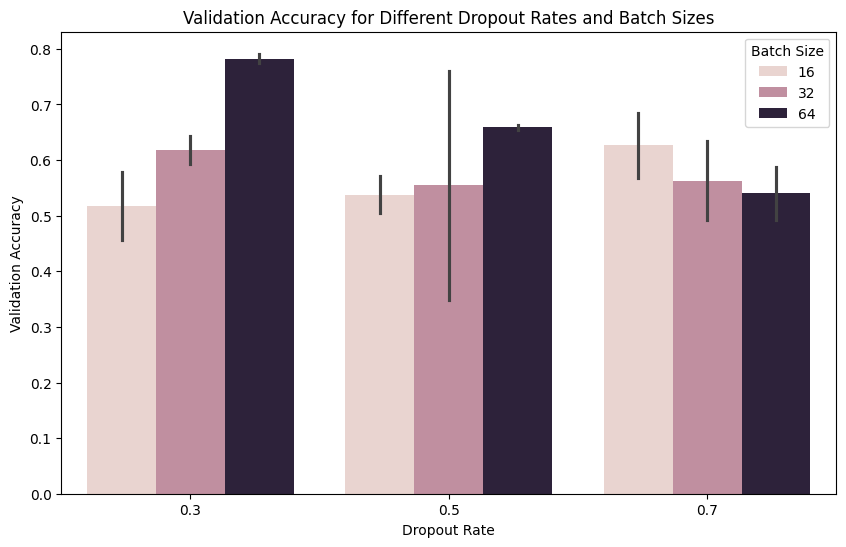

157/157 [==============================] - 1s 8ms/step

Best Model Evaluation on Validation Set:
Accuracy: 0.7912
Sensitivity: 0.7912
Specificity: 0.8956


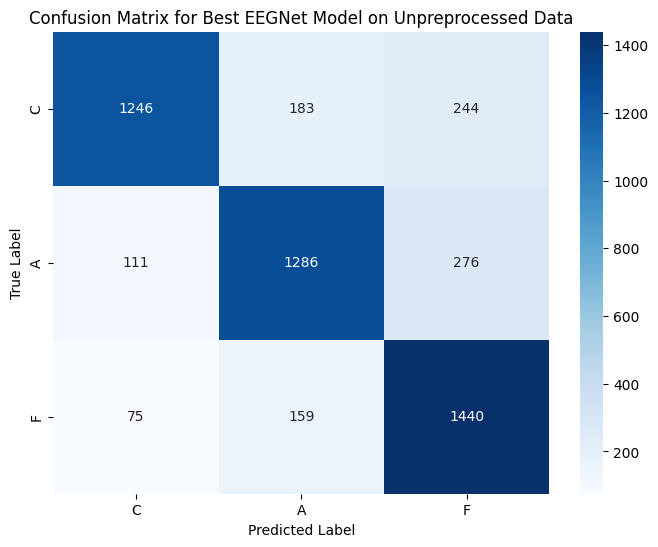

In [ ]:
# GRID SEARCH Unpreproccessed
import os
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Dense, Flatten, BatchNormalization,
                                     Activation, Dropout)
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.utils import resample
import itertools

# 1. Data Loading

# Update the data path to your dataset directory
data_path = '/content/drive/MyDrive/Thesis_data/unpreprocessed'

# Read participants.tsv to get subject IDs and labels
participants_tsv = os.path.join(data_path, '/content/drive/MyDrive/EEGDAT/participants.tsv')
participants_df = pd.read_csv(participants_tsv, sep='\t')

# Map diagnoses to numerical labels using 'Group' column
diagnosis_mapping = {'C': 0, 'A': 1, 'F': 2}
participants_df['label'] = participants_df['Group'].map(diagnosis_mapping)

# Create a dictionary of labels
labels = dict(zip(participants_df['participant_id'], participants_df['label']))

# List of subject IDs
subject_ids = participants_df['participant_id'].tolist()

# Function to get EEG file path
def get_eeg_file(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    eeg_file = None
    if not os.path.exists(sub_folder):
        print(f"Directory {sub_folder} does not exist for subject {sub_id}")
        return None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.set') or file.endswith('_eeg.SET'):
            eeg_file = os.path.join(sub_folder, file)
            break
    if eeg_file is None:
        print(f"No EEG file found in {sub_folder} for subject {sub_id}")
    return eeg_file

# Function to read channel information
def read_channel_info(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    channels_tsv = None
    if not os.path.exists(sub_folder):
        return None
    for file in os.listdir(sub_folder):
        if file.endswith('_channels.tsv') or file.endswith('_CHANNELS.TSV'):
            channels_tsv = os.path.join(sub_folder, file)
            break
    if channels_tsv:
        channels_df = pd.read_csv(channels_tsv, sep='\t')
        return channels_df
    else:
        return None

# Function to load raw EEG data without preprocessing
def load_raw_eeg(sub_id):
    eeg_file = get_eeg_file(sub_id)
    if eeg_file is None:
        print(f"No EEG file found for {sub_id}. Skipping.")
        return None

    # Load raw EEG data using EEGLAB reader
    try:
        raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
    except Exception as e:
        print(f"Error loading EEG data for {sub_id}: {e}")
        return None

    return raw

# 2. EEGNet Model Implementation

def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16,
           norm_rate=0.25, dropoutType='Dropout'):
    """
    EEGNet model as per the original architecture.
    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError("dropoutType must be one of 'Dropout' or 'SpatialDropout2D'")

    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D,
                             use_bias=False, depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classification block
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=tf.keras.constraints.MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    return model

# 3. Data Preparation

# Initialize lists to store data and labels for raw data
X_raw = []
y_raw = []

for sub_id in subject_ids:
    print(f"Processing {sub_id}...")

    # Load raw EEG data without preprocessing
    raw = load_raw_eeg(sub_id)
    if raw is None:
        continue

    # Optional: Set channel types if necessary
    channels_df = read_channel_info(sub_id)
    if channels_df is not None:
        ch_names = channels_df['name'].tolist()
        ch_types = channels_df['type'].str.lower().tolist()
        mapping = dict(zip(ch_names, ch_types))
        raw.set_channel_types(mapping)

    # Get data from raw object
    data = raw.get_data()  # Shape: (n_channels, n_times)

    # Since EEGNet expects epochs, we need to create epochs from the raw data
    # We'll create fixed-length epochs without any event-related processing

    # Create fixed-length epochs (e.g., 2 seconds)
    events = mne.make_fixed_length_events(raw, start=0, duration=2.0)
    event_id = {'Rest': 1}

    # Epoching
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Get the data from epochs
    data_epochs = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    if data_epochs.size == 0:
        print(f"No data in epochs for {sub_id}. Skipping.")
        continue

    print(f"Data shape for {sub_id}: {data_epochs.shape}")

    # Append to raw dataset
    X_raw.extend(data_epochs)
    y_raw.extend([labels[sub_id]] * data_epochs.shape[0])

# 4. Data Conversion and Balancing

# Convert lists to numpy arrays
X_raw = np.array(X_raw)  # Shape: (total_epochs, n_channels, n_times)
y_raw = np.array(y_raw)

# Balance the dataset
def balance_dataset(X, y):
    # Find the unique classes and their counts
    class_counts = Counter(y)
    print(f"Class counts before balancing: {class_counts}")

    # Find the minimum class count
    min_count = min(class_counts.values())
    print(f"Minimum class count: {min_count}")

    # Separate data by class
    classes = np.unique(y)
    X_balanced = []
    y_balanced = []
    for cls in classes:
        idxs = np.where(y == cls)[0]
        X_cls = X[idxs]
        y_cls = y[idxs]
        # Downsample to min_count
        X_cls_downsampled, y_cls_downsampled = resample(
            X_cls, y_cls,
            replace=False,
            n_samples=min_count,
            random_state=42
        )
        X_balanced.append(X_cls_downsampled)
        y_balanced.append(y_cls_downsampled)

    # Concatenate balanced classes
    X_balanced = np.concatenate(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    # Shuffle the data
    idxs = np.arange(len(y_balanced))
    np.random.shuffle(idxs)
    X_balanced = X_balanced[idxs]
    y_balanced = y_balanced[idxs]

    # Print class counts after balancing
    print(f"Class counts after balancing: {Counter(y_balanced)}")

    return X_balanced, y_balanced

# Balance the dataset
X_raw, y_raw = balance_dataset(X_raw, y_raw)

# Reshape data to fit the model input
X_raw = X_raw[..., np.newaxis]  # Shape: (samples, channels, times, 1)

# One-hot encode the labels
num_classes = len(np.unique(y_raw))
y_raw_cat = to_categorical(y_raw, num_classes)

# Split the data into training and validation sets
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_raw, y_raw_cat, test_size=0.2, random_state=42, stratify=y_raw)

# 5. Grid Search for Hyperparameter Tuning

# Define parameter grid for hyperparameter tuning
param_grid = {
    'dropoutRate': [0.3, 0.5, 0.7],  # Dropout rate
    'norm_rate': [0.25, 0.5],        # Max norm constraint
    'batch_size': [16, 32, 64]       # Batch size
}

# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average='macro')
    # Specificity calculation for multiclass
    specificity = []
    for i in range(num_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp))
    specificity = np.mean(specificity)
    return acc, sensitivity, specificity, cm

# Initialize variables to store the best results
best_acc = 0
best_params = None
results = []

# Create all combinations of hyperparameters
param_combinations = list(itertools.product(param_grid['dropoutRate'],
                                            param_grid['norm_rate'],
                                            param_grid['batch_size']))

print(f"Total combinations: {len(param_combinations)}")

# Loop over all combinations
for dropoutRate, norm_rate, batch_size in param_combinations:
    print(f"\nTraining with dropoutRate={dropoutRate}, norm_rate={norm_rate}, batch_size={batch_size}")

    # Create the EEGNet model with current hyperparameters
    model = EEGNet(nb_classes=num_classes,
                   Chans=X_train_raw.shape[1],
                   Samples=X_train_raw.shape[2],
                   dropoutRate=dropoutRate,
                   norm_rate=norm_rate)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_raw, y_train_raw,
                        epochs=50,
                        batch_size=batch_size,
                        validation_data=(X_val_raw, y_val_raw),
                        verbose=0)

    # Evaluate the model on the validation set
    y_pred_val = model.predict(X_val_raw)
    y_pred_val_cls = np.argmax(y_pred_val, axis=1)
    y_true_val_cls = np.argmax(y_val_raw, axis=1)

    acc, sens, spec, cm = evaluate_model(y_true_val_cls, y_pred_val_cls)

    print(f"Validation Accuracy: {acc:.4f}")

    # Store the results
    results.append({
        'dropoutRate': dropoutRate,
        'norm_rate': norm_rate,
        'batch_size': batch_size,
        'accuracy': acc,
        'sensitivity': sens,
        'specificity': spec,
        'confusion_matrix': cm
    })

    # Update best parameters if current model is better
    if acc > best_acc:
        best_acc = acc
        best_params = {
            'dropoutRate': dropoutRate,
            'norm_rate': norm_rate,
            'batch_size': batch_size
        }
        # Save the best model
        model_save_path = '/content/drive/MyDrive/Thesis_data/code'
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)
        best_model_path = os.path.join(model_save_path, 'best_model.h5')
        model.save(best_model_path)
        print(f"New best model saved to {best_model_path}")

# 6. Reporting the Best Hyperparameters

print("\nGrid Search Completed.")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Best Hyperparameters: {best_params}")

# 7. Detailed Results

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df[['dropoutRate', 'norm_rate', 'batch_size', 'accuracy']])

# Optionally, plot the accuracies for different hyperparameter combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting accuracies for different dropout rates
plt.figure(figsize=(10, 6))
sns.barplot(x='dropoutRate', y='accuracy', hue='batch_size', data=results_df)
plt.title('Validation Accuracy for Different Dropout Rates and Batch Sizes')
plt.ylabel('Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.legend(title='Batch Size')
plt.show()

# 8. Load and Evaluate the Best Model on the Validation Set

# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

# Evaluate the best model on the validation set
y_pred_val = best_model.predict(X_val_raw)
y_pred_val_cls = np.argmax(y_pred_val, axis=1)
y_true_val_cls = np.argmax(y_val_raw, axis=1)

acc_best, sens_best, spec_best, cm_best = evaluate_model(y_true_val_cls, y_pred_val_cls)

print(f"\nBest Model Evaluation on Validation Set:")
print(f"Accuracy: {acc_best:.4f}")
print(f"Sensitivity: {sens_best:.4f}")
print(f"Specificity: {spec_best:.4f}")

# Plot confusion matrix for the best model
class_labels = ['C', 'A', 'F']  # Adjust according to your mapping

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm_best, 'Best EEGNet Model on Unpreprocessed Data')


In [ ]:
# GRID Search
import os
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Dense, Flatten, BatchNormalization,
                                     Activation, Dropout)
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.utils import resample
import itertools

# 1. Data Loading

# Update the data path to your dataset directory
data_path = '/content/drive/MyDrive/Thesis_data/preprocessed'  # Assuming preprocessed data

# Define the path to save preprocessed data
preprocessed_data_path = '/content/drive/MyDrive/EEGDAT/preprocessed_data'

# Create the directory if it doesn't exist
if not os.path.exists(preprocessed_data_path):
    os.makedirs(preprocessed_data_path)

# Read participants.tsv to get subject IDs and labels
participants_tsv = os.path.join(data_path, '/content/drive/MyDrive/EEGDAT/participants.tsv')
participants_df = pd.read_csv(participants_tsv, sep='\t')

# Map diagnoses to numerical labels using 'Group' column
diagnosis_mapping = {'C': 0, 'A': 1, 'F': 2}
participants_df['label'] = participants_df['Group'].map(diagnosis_mapping)

# Create a dictionary of labels
labels = dict(zip(participants_df['participant_id'], participants_df['label']))

# List of subject IDs
subject_ids = participants_df['participant_id'].tolist()

# Function to get EEG file path
def get_eeg_file(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    eeg_file = None
    if not os.path.exists(sub_folder):
        print(f"Directory {sub_folder} does not exist for subject {sub_id}")
        return None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.set') or file.endswith('_eeg.SET'):
            eeg_file = os.path.join(sub_folder, file)
            break
    if eeg_file is None:
        print(f"No EEG file found in {sub_folder} for subject {sub_id}")
    return eeg_file

# Function to read channel information
def read_channel_info(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    channels_tsv = None
    if not os.path.exists(sub_folder):
        return None
    for file in os.listdir(sub_folder):
        if file.endswith('_channels.tsv') or file.endswith('_CHANNELS.TSV'):
            channels_tsv = os.path.join(sub_folder, file)
            break
    if channels_tsv:
        channels_df = pd.read_csv(channels_tsv, sep='\t')
        return channels_df
    else:
        return None

# Function to read metadata from JSON file
def read_metadata(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    json_file = None
    if not os.path.exists(sub_folder):
        return None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.json') or file.endswith('_EEG.JSON'):
            json_file = os.path.join(sub_folder, file)
            break
    if json_file:
        with open(json_file, 'r') as f:
            metadata = json.load(f)
        return metadata
    else:
        return None

# 2. Preprocessing Functions

from mne.preprocessing import ICA  # Make sure to import ICA

def preprocess_eeg(raw, channels_df=None, metadata=None):
    """
    Preprocess the raw EEG data.
    """
    # If channel information is provided, set channel types
    if channels_df is not None:
        ch_names = channels_df['name'].tolist()
        # Convert channel types to lowercase to match MNE's expected types
        ch_types = channels_df['type'].str.lower().tolist()
        mapping = dict(zip(ch_names, ch_types))
        raw.set_channel_types(mapping)

    # Set the EEG montage (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    # Re-reference the data to average of A1 and A2 (if present)
    if 'A1' in raw.ch_names and 'A2' in raw.ch_names:
        raw.set_eeg_reference(['A1', 'A2'])
    else:
        raw.set_eeg_reference('average', projection=False)

    # Band-pass filter (0.5–45 Hz)
    raw.filter(0.5, 45., fir_design='firwin')

    # Independent Component Analysis (ICA) with automatic artifact rejection
    ica = ICA(n_components=15, random_state=97, max_iter='auto')
    ica.fit(raw)

    # Use 'Fp1' and 'Fp2' as proxy EOG channels
    eog_channels = ['Fp1', 'Fp2']
    available_eog_channels = [ch for ch in eog_channels if ch in raw.ch_names]

    if available_eog_channels:
        # Use the available EOG proxy channels for artifact detection
        eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=available_eog_channels)
    else:
        print("No frontal channels available for EOG detection. Proceeding without EOG correction.")
        eog_indices = []

    # Exclude identified EOG components
    ica.exclude.extend(eog_indices)

    # Apply ICA to remove artifacts
    raw = ica.apply(raw)

    # Create fixed-length epochs (e.g., 2 seconds)
    events = mne.make_fixed_length_events(raw, start=0, duration=2.0)
    event_id = {'Rest': 1}

    # Epoching
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Exclude bad epochs
    epochs.drop_bad()

    return epochs

# 3. EEGNet Model Implementation

def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16,
           norm_rate=0.25, dropoutType='Dropout'):
    """
    EEGNet model as per the original architecture.
    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError("dropoutType must be one of 'Dropout' or 'SpatialDropout2D'")

    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D,
                             use_bias=False, depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classification block
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=tf.keras.constraints.MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    return model

# 4. Data Preparation

# Initialize lists to store data and labels
X_baseline = []
y_baseline = []

for sub_id in subject_ids:
    print(f"Processing {sub_id}...")

    # Define the path to the preprocessed data file
    preprocessed_file = os.path.join(preprocessed_data_path, f"{sub_id}_epo.fif")

    if os.path.exists(preprocessed_file):
        # Load preprocessed data
        print(f"Loading preprocessed data for {sub_id}...")
        epochs = mne.read_epochs(preprocessed_file, preload=True)
    else:
        # Get EEG file path
        eeg_file = get_eeg_file(sub_id)
        if eeg_file is None:
            print(f"No EEG file found for {sub_id}. Skipping.")
            continue

        # Load raw EEG data using EEGLAB reader
        try:
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
        except Exception as e:
            print(f"Error loading EEG data for {sub_id}: {e}")
            continue

        # Read channel information
        channels_df = read_channel_info(sub_id)

        # Read metadata (if needed)
        metadata = read_metadata(sub_id)

        # Preprocess the data
        try:
            epochs = preprocess_eeg(raw, channels_df, metadata)
        except Exception as e:
            print(f"Error preprocessing EEG data for {sub_id}: {e}")
            continue

        # Save the preprocessed data
        epochs.save(preprocessed_file, overwrite=True)
        print(f"Preprocessed data saved for {sub_id}.")

    # Get the data from epochs
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    if data.size == 0:
        print(f"No data in epochs for {sub_id}. Skipping.")
        continue

    print(f"Data shape for {sub_id}: {data.shape}")

    # Append to baseline dataset
    X_baseline.extend(data)
    y_baseline.extend([labels[sub_id]] * data.shape[0])

# 5. Data Conversion and Balancing

# Convert lists to numpy arrays
X_baseline = np.array(X_baseline)  # Shape: (total_epochs, n_channels, n_times)
y_baseline = np.array(y_baseline)

# Balance the dataset
def balance_dataset(X, y):
    # Find the unique classes and their counts
    class_counts = Counter(y)
    print(f"Class counts before balancing: {class_counts}")

    # Find the minimum class count
    min_count = min(class_counts.values())
    print(f"Minimum class count: {min_count}")

    # Separate data by class
    classes = np.unique(y)
    X_balanced = []
    y_balanced = []
    for cls in classes:
        idxs = np.where(y == cls)[0]
        X_cls = X[idxs]
        y_cls = y[idxs]
        # Downsample to min_count
        X_cls_downsampled, y_cls_downsampled = resample(
            X_cls, y_cls,
            replace=False,
            n_samples=min_count,
            random_state=42
        )
        X_balanced.append(X_cls_downsampled)
        y_balanced.append(y_cls_downsampled)

    # Concatenate balanced classes
    X_balanced = np.concatenate(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    # Shuffle the data
    idxs = np.arange(len(y_balanced))
    np.random.shuffle(idxs)
    X_balanced = X_balanced[idxs]
    y_balanced = y_balanced[idxs]

    # Print class counts after balancing
    print(f"Class counts after balancing: {Counter(y_balanced)}")

    return X_balanced, y_balanced

# Balance the dataset
X_baseline, y_baseline = balance_dataset(X_baseline, y_baseline)

# Reshape data to fit the model input
X_baseline = X_baseline[..., np.newaxis]  # Shape: (samples, channels, times, 1)

# One-hot encode the labels
num_classes = len(np.unique(y_baseline))
y_baseline_cat = to_categorical(y_baseline, num_classes)

# Split the data into training and validation sets
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_baseline, y_baseline_cat, test_size=0.2, random_state=42, stratify=y_baseline)

# 6. Grid Search for Hyperparameter Tuning

# Define parameter grid for hyperparameter tuning
param_grid = {
    'dropoutRate': [0.3, 0.5, 0.7],  # Dropout rate
    'norm_rate': [0.25, 0.5],        # Max norm constraint
    'batch_size': [16, 32, 64]       # Batch size
}

# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average='macro')
    # Specificity calculation for multiclass
    specificity = []
    for i in range(num_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp))
    specificity = np.mean(specificity)
    return acc, sensitivity, specificity, cm

# Initialize variables to store the best results
best_acc = 0
best_params = None
results = []

# Create all combinations of hyperparameters
param_combinations = list(itertools.product(param_grid['dropoutRate'],
                                            param_grid['norm_rate'],
                                            param_grid['batch_size']))

print(f"Total combinations: {len(param_combinations)}")

# Loop over all combinations
for dropoutRate, norm_rate, batch_size in param_combinations:
    print(f"\nTraining with dropoutRate={dropoutRate}, norm_rate={norm_rate}, batch_size={batch_size}")

    # Create the EEGNet model with current hyperparameters
    model_base = EEGNet(nb_classes=num_classes,
                        Chans=X_train_base.shape[1],
                        Samples=X_train_base.shape[2],
                        dropoutRate=dropoutRate,
                        norm_rate=norm_rate)

    # Compile the model
    model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model_base.fit(X_train_base, y_train_base,
                             epochs=50,
                             batch_size=batch_size,
                             validation_data=(X_val_base, y_val_base),
                             verbose=0)

    # Evaluate the model on the validation set
    y_pred_val = model_base.predict(X_val_base)
    y_pred_val_cls = np.argmax(y_pred_val, axis=1)
    y_true_val_cls = np.argmax(y_val_base, axis=1)

    acc, sens, spec, cm = evaluate_model(y_true_val_cls, y_pred_val_cls)

    print(f"Validation Accuracy: {acc:.4f}")

    # Store the results
    results.append({
        'dropoutRate': dropoutRate,
        'norm_rate': norm_rate,
        'batch_size': batch_size,
        'accuracy': acc,
        'sensitivity': sens,
        'specificity': spec,
        'confusion_matrix': cm
    })

    # Update best parameters if current model is better
    if acc > best_acc:
        best_acc = acc
        best_params = {
            'dropoutRate': dropoutRate,
            'norm_rate': norm_rate,
            'batch_size': batch_size
        }
        # Save the best model
        model_save_path = '/content/drive/MyDrive/Thesis_data/code'
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)
        best_model_path = os.path.join(model_save_path, 'best_model_baseline.h5')
        model_base.save(best_model_path)
        print(f"New best model saved to {best_model_path}")

# 7. Reporting the Best Hyperparameters

print("\nGrid Search Completed.")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Best Hyperparameters: {best_params}")

# 8. Detailed Results

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df[['dropoutRate', 'norm_rate', 'batch_size', 'accuracy']])

# Optionally, plot the accuracies for different hyperparameter combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting accuracies for different dropout rates
plt.figure(figsize=(10, 6))
sns.barplot(x='dropoutRate', y='accuracy', hue='batch_size', data=results_df)
plt.title('Validation Accuracy for Different Dropout Rates and Batch Sizes')
plt.ylabel('Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.legend(title='Batch Size')
plt.show()

# 9. Load and Evaluate the Best Model on the Validation Set

# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

# Evaluate the best model on the validation set
y_pred_val = best_model.predict(X_val_base)
y_pred_val_cls = np.argmax(y_pred_val, axis=1)
y_true_val_cls = np.argmax(y_val_base, axis=1)

acc_best, sens_best, spec_best, cm_best = evaluate_model(y_true_val_cls, y_pred_val_cls)

print(f"\nBest Model Evaluation on Validation Set:")
print(f"Accuracy: {acc_best:.4f}")
print(f"Sensitivity: {sens_best:.4f}")
print(f"Specificity: {spec_best:.4f}")

# Plot confusion matrix for the best model
class_labels = ['C', 'A', 'F']  # Adjust according to your mapping

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm_best, 'Best Baseline EEGNet Model')


Processing sub-001...
Loading preprocessed data for sub-001...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-001_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-001: (299, 19, 1001)
Processing sub-002...
Loading preprocessed data for sub-002...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-002_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-002: (396, 19, 1001)
Processing sub-003...
Loading preprocessed data for sub-003...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-003_epo.fif ...
    Found the data of interest:
        t =       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved to /content/drive/MyDrive/Thesis_data/code/best_model_baseline.h5

Training with dropoutRate=0.3, norm_rate=0.25, batch_size=32


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping
# Import necessary libraries
import os
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import ICA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from scipy.stats import ttest_ind
import pywt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Dense, Flatten, BatchNormalization,
                                     Activation, Dropout)
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import json

# 1. Data Loading

# Update the data path to your dataset directory
data_path = '/content/drive/MyDrive/Thesis_data/unpreprocessed'

# Define the path to save preprocessed data
preprocessed_data_path = '/content/drive/MyDrive/EEGDAT/preprocessed_data'

# Create the directory if it doesn't exist
if not os.path.exists(preprocessed_data_path):
    os.makedirs(preprocessed_data_path)

# Read participants.tsv to get subject IDs and labels
participants_tsv = os.path.join(data_path, '/content/drive/MyDrive/EEGDAT/participants.tsv')
participants_df = pd.read_csv(participants_tsv, sep='\t')

# Map diagnoses to numerical labels using 'Group' column
diagnosis_mapping = {'C': 0, 'A': 1, 'F': 2}
participants_df['label'] = participants_df['Group'].map(diagnosis_mapping)

# Create a dictionary of labels
labels = dict(zip(participants_df['participant_id'], participants_df['label']))

# List of subject IDs
subject_ids = participants_df['participant_id'].tolist()

# Function to get EEG file path
def get_eeg_file(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    eeg_file = None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.set') or file.endswith('_eeg.SET'):
            eeg_file = os.path.join(sub_folder, file)
            break
    if eeg_file is None:
        print(f"No EEG file found in {sub_folder} for subject {sub_id}")
    return eeg_file

# Function to read channel information
def read_channel_info(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    channels_tsv = None
    for file in os.listdir(sub_folder):
        if file.endswith('_channels.tsv') or file.endswith('_CHANNELS.TSV'):
            channels_tsv = os.path.join(sub_folder, file)
            break
    if channels_tsv:
        channels_df = pd.read_csv(channels_tsv, sep='\t')
        return channels_df
    else:
        return None

# Function to read metadata from JSON file
def read_metadata(sub_id):
    sub_folder = os.path.join(data_path, sub_id, 'eeg')
    json_file = None
    for file in os.listdir(sub_folder):
        if file.endswith('_eeg.json') or file.endswith('_EEG.JSON'):
            json_file = os.path.join(sub_folder, file)
            break
    if json_file:
        with open(json_file, 'r') as f:
            metadata = json.load(f)
        return metadata
    else:
        return None

# 2. Preprocessing Functions

def preprocess_eeg(raw, channels_df=None, metadata=None):
    """
    Preprocess the raw EEG data.
    """
    # If channel information is provided, set channel types
    if channels_df is not None:
        ch_names = channels_df['name'].tolist()
        # Convert channel types to lowercase to match MNE's expected types
        ch_types = channels_df['type'].str.lower().tolist()
        mapping = dict(zip(ch_names, ch_types))
        raw.set_channel_types(mapping)

    # Set the EEG montage (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    # Re-reference the data to average of A1 and A2 (if present)
    if 'A1' in raw.ch_names and 'A2' in raw.ch_names:
        raw.set_eeg_reference(['A1', 'A2'])
    else:
        raw.set_eeg_reference('average', projection=False)

    # Band-pass filter (0.5–45 Hz)
    raw.filter(0.5, 45., fir_design='firwin')

    # Independent Component Analysis (ICA) with automatic artifact rejection
    ica = ICA(n_components=15, random_state=97, max_iter='auto')
    ica.fit(raw)

    # Use 'Fp1' and 'Fp2' as proxy EOG channels
    eog_channels = ['Fp1', 'Fp2']
    available_eog_channels = [ch for ch in eog_channels if ch in raw.ch_names]

    if available_eog_channels:
        # Use the available EOG proxy channels for artifact detection
        eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=available_eog_channels)
    else:
        print("No frontal channels available for EOG detection. Proceeding without EOG correction.")
        eog_indices = []

    # Exclude identified EOG components
    ica.exclude.extend(eog_indices)

    # Apply ICA to remove artifacts
    raw = ica.apply(raw)

    # Create fixed-length epochs (e.g., 2 seconds)
    events = mne.make_fixed_length_events(raw, start=0, duration=2.0)
    event_id = {'Rest': 1}

    # Epoching
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=2.0, baseline=None, preload=True)

    # Exclude bad epochs
    epochs.drop_bad()

    return epochs

# 3. Feature Extraction Methods

# 3.1 Discrete Wavelet Transform (DWT)
def extract_features_dwt(epochs):
    """
    Extract features using Discrete Wavelet Transform from epochs.
    """
    features = []
    for epoch in epochs.get_data():
        epoch_features = []
        for ch in range(epoch.shape[0]):
            coeffs = pywt.wavedec(epoch[ch, :], 'db4', level=5)
            coeffs_flat = np.hstack(coeffs)
            epoch_features.extend(coeffs_flat)
        features.append(epoch_features)
    return np.array(features)

# 3.2 Principal Component Analysis (PCA) with Cross-Covariance (CCOV)
def extract_features_pca_ccov(epochs):
    """
    Extract features using PCA with Cross-Covariance from epochs.
    """
    features = []
    for epoch in epochs.get_data():
        # Compute cross-covariance matrix
        cov_matrix = np.cov(epoch)
        # Apply PCA
        pca = PCA(n_components=10)  # Adjust the number of components as needed
        pca.fit(cov_matrix)
        epoch_features = pca.components_.flatten()
        features.append(epoch_features)
    return np.array(features)

# from sklearn.preprocessing import StandardScaler
# def extract_features_pca_ccov(epochs):
#     """
#     Extract features using PCA with Cross-Covariance from epochs.
#     """
#     features = []
#     for epoch in epochs.get_data():
#         try:
#             # Compute cross-covariance matrix for the epoch
#             cov_matrix = np.cov(epoch)

#             # Standardize the covariance matrix
#             scaler = StandardScaler()
#             cov_matrix_std = scaler.fit_transform(cov_matrix)

#             # Apply PCA
#             pca = PCA()
#             pca.fit(cov_matrix_std)

#             # Determine the number of components that explain 95% of the variance
#             explained_variance = np.cumsum(pca.explained_variance_ratio_)
#             n_components = np.argmax(explained_variance >= 0.95) + 1
#             if n_components == 0:
#                 n_components = 1  # Ensure at least one component is selected

#             # Transform the data using the selected number of components
#             pca = PCA(n_components=n_components)
#             principal_components = pca.fit_transform(cov_matrix_std)

#             # Flatten the principal components to create feature vector
#             epoch_features = principal_components.flatten()
#             features.append(epoch_features)
#         except Exception as e:
#             print(f"Error processing an epoch: {e}")
#             continue  # Skip this epoch if there's an error
#     return np.array(features)






# 4. EEGNet Model Implementation

def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16,
           norm_rate=0.25, dropoutType='Dropout'):
    """
    EEGNet model as per the original architecture.
    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError("dropoutType must be one of 'Dropout' or 'SpatialDropout2D'")

    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D,
                             use_bias=False, depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classification block
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=tf.keras.constraints.MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    return model

# 5. Data Preparation and Feature Extraction

# Initialize lists to store data and labels
X_baseline = []
y_baseline = []
X_dwt = []
y_dwt = []
X_pca = []
y_pca = []

for sub_id in subject_ids:
    print(f"Processing {sub_id}...")

    # Define the path to the preprocessed data file
    preprocessed_file = os.path.join(preprocessed_data_path, f"{sub_id}_epo.fif")

    if os.path.exists(preprocessed_file):
        # Load preprocessed data
        print(f"Loading preprocessed data for {sub_id}...")
        epochs = mne.read_epochs(preprocessed_file, preload=True)
    else:
        # Get EEG file path
        eeg_file = get_eeg_file(sub_id)
        if eeg_file is None:
            print(f"No EEG file found for {sub_id}. Skipping.")
            continue

        # Load raw EEG data using EEGLAB reader
        try:
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
        except Exception as e:
            print(f"Error loading EEG data for {sub_id}: {e}")
            continue

        # Read channel information
        channels_df = read_channel_info(sub_id)

        # Read metadata (if needed)
        metadata = read_metadata(sub_id)

        # Preprocess the data
        try:
            epochs = preprocess_eeg(raw, channels_df, metadata)
        except Exception as e:
            print(f"Error preprocessing EEG data for {sub_id}: {e}")
            continue

        # Save the preprocessed data
        epochs.save(preprocessed_file, overwrite=True)
        print(f"Preprocessed data saved for {sub_id}.")

    # Get the data from epochs
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    if data.size == 0:
        print(f"No data in epochs for {sub_id}. Skipping.")
        continue

    print(f"Data shape for {sub_id}: {data.shape}")

    # Append to baseline dataset
    X_baseline.extend(data)
    y_baseline.extend([labels[sub_id]] * data.shape[0])

    # Feature Extraction: DWT
    try:
        features_dwt = extract_features_dwt(epochs)
        X_dwt.extend(features_dwt)
        y_dwt.extend([labels[sub_id]] * features_dwt.shape[0])
    except Exception as e:
        print(f"Error in DWT feature extraction for {sub_id}: {e}")
        continue

    # Feature Extraction: PCA with CCOV
    try:
        features_pca = extract_features_pca_ccov(epochs)
        X_pca.extend(features_pca)
        y_pca.extend([labels[sub_id]] * features_pca.shape[0])
    except Exception as e:
        print(f"Error in PCA feature extraction for {sub_id}: {e}")
        continue

# 6. Data Conversion and Balancing

# Convert lists to numpy arrays
X_baseline = np.array(X_baseline)  # Shape: (total_epochs, n_channels, n_times)
y_baseline = np.array(y_baseline)
X_dwt = np.array(X_dwt)
y_dwt = np.array(y_dwt)
X_pca = np.array(X_pca)
y_pca = np.array(y_pca)

# Check if data is loaded
if len(X_baseline) == 0 or len(y_baseline) == 0:
    print("No data was loaded. Please check data loading and preprocessing steps.")
else:
    # Balance the datasets
    from collections import Counter
    from sklearn.utils import resample

    # Function to balance dataset
    def balance_dataset(X, y):
        # Find the unique classes and their counts
        class_counts = Counter(y)
        print(f"Class counts before balancing: {class_counts}")

        # Find the minimum class count
        min_count = min(class_counts.values())
        print(f"Minimum class count: {min_count}")

        # Separate data by class
        classes = np.unique(y)
        X_balanced = []
        y_balanced = []
        for cls in classes:
            idxs = np.where(y == cls)[0]
            X_cls = X[idxs]
            y_cls = y[idxs]
            # Downsample to min_count
            X_cls_downsampled, y_cls_downsampled = resample(
                X_cls, y_cls,
                replace=False,
                n_samples=min_count,
                random_state=42
            )
            X_balanced.append(X_cls_downsampled)
            y_balanced.append(y_cls_downsampled)

        # Concatenate balanced classes
        X_balanced = np.concatenate(X_balanced)
        y_balanced = np.concatenate(y_balanced)

        # Shuffle the data
        idxs = np.arange(len(y_balanced))
        np.random.shuffle(idxs)
        X_balanced = X_balanced[idxs]
        y_balanced = y_balanced[idxs]

        # Print class counts after balancing
        print(f"Class counts after balancing: {Counter(y_balanced)}")

        return X_balanced, y_balanced

    # Balance the datasets
    X_baseline, y_baseline = balance_dataset(X_baseline, y_baseline)
    X_dwt, y_dwt = balance_dataset(X_dwt, y_dwt)
    X_pca, y_pca = balance_dataset(X_pca, y_pca)

    # For EEGNet, reshape data to fit the model input
    X_baseline = X_baseline[..., np.newaxis]  # Shape: (samples, channels, times, 1)

    # Apply PCA to the balanced DWT features
    from sklearn.decomposition import PCA

    def apply_pca(X, n_components=50):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
        return X_pca, pca

    # Apply PCA to X_dwt
    X_pca_dwt, pca_dwt = apply_pca(X_dwt, n_components=50)
    y_pca_dwt = y_dwt  # Labels remain the same

    # One-hot encode the labels for classification
    num_classes = len(np.unique(y_baseline))
    y_baseline_cat = to_categorical(y_baseline, num_classes)
    y_dwt_cat = to_categorical(y_dwt, num_classes)
    y_pca_cat = to_categorical(y_pca, num_classes)
    y_pca_dwt_cat = to_categorical(y_pca_dwt, num_classes)

    # Split the data into training and testing sets
    X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        X_baseline, y_baseline_cat, test_size=0.2, random_state=42, stratify=y_baseline)

    X_train_dwt, X_test_dwt, y_train_dwt, y_test_dwt = train_test_split(
        X_dwt, y_dwt_cat, test_size=0.2, random_state=42, stratify=y_dwt)

    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
        X_pca, y_pca_cat, test_size=0.2, random_state=42, stratify=y_pca)

    X_train_pca_dwt, X_test_pca_dwt, y_train_pca_dwt, y_test_pca_dwt = train_test_split(
        X_pca_dwt, y_pca_dwt_cat, test_size=0.2, random_state=42, stratify=y_pca_dwt)



# Define parameter grid for hyperparameter tuning
param_grid = {
    'dropoutRate': [0.3, 0.5, 0.7],  # Dropout rate
    'norm_rate': [0.25, 0.5],        # Max norm constraint
    'batch_size': [16, 32,64]            # Batch size
}

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Function to perform grid search for EEGNet
def grid_search_eegnet(X_train, y_train, X_val, y_val, nb_classes, Chans, Samples):
    best_params = None
    best_acc = 0
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Testing parameters: {params}")

        # Initialize model with current params
        model = EEGNet(nb_classes=nb_classes, Chans=Chans, Samples=Samples,
                       dropoutRate=params['dropoutRate'], norm_rate=params['norm_rate'])

        # Compile model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model
        history = model.fit(X_train, y_train,
                            epochs=50,
                            batch_size=params['batch_size'],
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)

        # Evaluate model
        val_acc = max(history.history['val_accuracy'])
        print(f"Validation Accuracy: {val_acc:.4f} with parameters: {params}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best parameters: {best_params} with Validation Accuracy: {best_acc:.4f}")
    return best_model, best_params

# Perform grid search for EEGNet model
best_model_base, best_params_base = grid_search_eegnet(
    X_train_base, y_train_base, X_test_base, y_test_base,
    nb_classes=num_classes, Chans=X_baseline.shape[1], Samples=X_baseline.shape[2]
)

# # Save the best EEGNet model
# best_model_base.save(os.path.join(model_save_path, 'best_model_base.h5'))
# print("Best Baseline model saved with parameters:", best_params_base)


# Grid search function for DWT and PCA models
def grid_search_dnn(X_train, y_train, X_val, y_val, input_shape):
    best_params = None
    best_acc = 0
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Testing parameters: {params}")

        # Initialize model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dropout(params['dropoutRate']),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(params['dropoutRate']),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model
        history = model.fit(X_train, y_train,
                            epochs=50,
                            batch_size=params['batch_size'],
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)

        # Evaluate model
        val_acc = max(history.history['val_accuracy'])
        print(f"Validation Accuracy: {val_acc:.4f} with parameters: {params}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best parameters: {best_params} with Validation Accuracy: {best_acc:.4f}")
    return best_model, best_params

# Perform grid search for DWT model
best_model_dwt, best_params_dwt = grid_search_dnn(X_train_dwt, y_train_dwt, X_test_dwt, y_test_dwt, input_shape=X_dwt.shape[1])

# Save the best DWT model
best_model_dwt.save(os.path.join(model_save_path, '/content/drive/MyDrive/EEGDAT/ModelsGrid/best_model_dwt.h5'))
# print("Best DWT model saved with parameters:", best_params_dwt)

# Perform grid search for PCA model
best_model_pca, best_params_pca = grid_search_dnn(X_train_pca, y_train_pca, X_test_pca, y_test_pca, input_shape=X_pca.shape[1])

# Save the best PCA model
best_model_pca.save(os.path.join(model_save_path, '/content/drive/MyDrive/EEGDAT/ModelsGrid/best_model_pca.h5'))
print("Best PCA model saved with parameters:", best_params_pca)


Processing sub-001...
Loading preprocessed data for sub-001...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-001_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-001: (299, 19, 1001)
Processing sub-002...
Loading preprocessed data for sub-002...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-002_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-002: (396, 19, 1001)
Processing sub-003...
Loading preprocessed data for sub-003...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-003_epo.fif ...
    Found the data of interest:
        t =       0

Processing sub-001...
Loading preprocessed data for sub-001...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-001_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-001: (299, 19, 1001)
Error in PCA feature extraction for sub-001: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (299,) + inhomogeneous part.
Processing sub-002...
Loading preprocessed data for sub-002...
Reading /content/drive/MyDrive/EEGDAT/preprocessed_data/sub-002_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Data shape for sub-002: 

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
]